In [1]:
### RUN EVERY TIME: ECONOMIC INDICES RELEASES HISTORY EXTRACTING

In [2]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd
import numpy as np
from datetime import date, datetime
from math import floor, ceil
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.x13 import x13_arima_analysis
from itertools import combinations_with_replacement
from sklearn.decomposition import PCA
import os
import gc
from joblib import Parallel, delayed
import re
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters # Plotting
register_matplotlib_converters() # Plotting
import seaborn as sns

#%load_ext line_profiler

In [3]:
### RUN ONLY WHEN ARIMA X13 SA LAUNCHING 

### Warnings hiding:
import warnings
warnings.filterwarnings('ignore')
### Seasonal adjustment module paths set up:
%env X13PATH = C:\Users\ighar\AppData\Roaming\jupyter\x13as
%env X12PATH = C:\Users\ighar\AppData\Roaming\jupyter\x13as
#%env

env: X13PATH=C:\Users\ighar\AppData\Roaming\jupyter\x13as
env: X12PATH=C:\Users\ighar\AppData\Roaming\jupyter\x13as


In [4]:
### VERSION CONTROL

from platform import python_version
print('pandas version: ', pd.__version__)
print('python version: ', python_version())

pandas version:  0.25.3
python version:  3.7.4


In [5]:
### RUN EVERY TIME: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable']
### Raw data path and sheets:
str_path_bb_idx_source = 'Data_Files/Source_Files/Bloomberg_Eco_Indices.xlsx'
str_us_sheet = 'US Eco Const'
str_all_sheet = 'All Eco Const'
### Flags data path and sheets:
str_path_bb_idx_flags = 'Data_Files/Source_Files/Bloomberg_Eco_Flags_Extended.xlsx'
str_flag_sheet = 'Bloomberg Description'
### Source data constants:
int_idx_cols = 12
### HDF file with converted source data:
str_path_bb_fcast_hdf = 'Data_Files/Source_Files/Bloomberg_Forecasts_matrix.h5' ### LINE TO ADD
str_key_flags = 'flags_exported' ### Acadian flags list
str_key_exported = 'all_idx_exported' ### Raw export with only replacing zero dates and after 2021-01-01 dates with np.NaN
str_key_raw_filled = 'all_idx_raw_filled' ### Raw export with initial dates, dates gaps, absent date columns filled
str_key_raw_history = 'raw_history' ### Export with all the corrections and fillings (restructured to [Index_Name -> Data_Date -> Observation_Date] | Value series)
str_key_bday_history = 'bday_history' ### Raw history vector with observation dates moved to nearest future business dates
str_key_types_info = 'types_info' ### Dataframe with 'Type_Prime' / 'Sub_Type' / 'Region' groups descriptions
str_key_flags_typed = 'flags_typed' ### Dataframe with economic indices descriptions taking into account 
str_key_survey_history = 'survey_history' ### Release values are replaced with Survey Medians to normalize it ### LINE TO ADD
str_key_norm_filled = 'all_idx_norm_filled' ### Normalized values with initial dates, dates gaps, absent date columns filled
str_key_cleared = 'all_idx_cleared' ### LINE TO ADD
str_key_weighted = 'all_idx_weighted' ### LINE TO ADD
str_key_announce = 'announce_factor' ### LINE TO ADD
str_key_announce_simple = 'announce_simple' ### LINE TO ADD
str_key_disagreement = 'disagreement_factor' ### LINE TO ADD
str_key_disagreement_simple = 'disagreement_simple' ### LINE TO ADD
str_key_revision = 'revision_factor' ### LINE TO ADD
str_key_revision_simple = 'revision_simple' ### LINE TO ADD
str_key_total_surprise = 'total_factor' ### LINE TO ADD
str_key_total_surprise_simple = 'total_simple' ### LINE TO ADD
### HDF file with matrices:
str_path_bb_matrix_ant_hdf = 'Data_Files/Source_Files/Matrix_Eco_Indices_ant.h5'
str_path_bb_matrix_mom_hdf = 'Data_Files/Source_Files/Matrix_Eco_Indices_mom.h5'
str_path_bb_matrix_qoq_hdf = 'Data_Files/Source_Files/Matrix_Eco_Indices_qoq.h5'
str_path_bb_matrix_yoy_hdf = 'Data_Files/Source_Files/Matrix_Eco_Indices_yoy.h5'
str_path_survey_matrix_ant_hdf = 'Data_Files/Source_Files/Matrix_Eco_Surveys_ant.h5'
str_path_survey_matrix_yoy_hdf = 'Data_Files/Source_Files/Matrix_Eco_Surveys_yoy.h5'
str_key_matrix_z = 'matrix_cube_z_scored'
### HDF file with diagonals:
str_path_bb_diag_hdf = 'Data_Files/Source_Files/Diag_Eco_Indices.h5'
str_key_diag_daily_raw = 'matrix_diagonal_raw'
str_key_diag_daily_ant = 'matrix_diagonal_ant'
str_key_diag_daily_mom = 'matrix_diagonal_mom'
str_key_diag_daily_qoq = 'matrix_diagonal_qoq'
str_key_diag_daily_yoy = 'matrix_diagonal_yoy'
str_key_diag_group_ant = 'groups_diagonal_ant'
str_key_diag_group_mom = 'groups_diagonal_mom'
str_key_diag_group_qoq = 'groups_diagonal_qoq'
str_key_diag_group_yoy = 'groups_diagonal_yoy'
str_key_diag_sub_ant = 'sub_types_diagonal_ant'
str_key_diag_sub_mom = 'sub_types_diagonal_mom'
str_key_diag_sub_qoq = 'sub_types_diagonal_qoq'
str_key_diag_sub_yoy = 'sub_types_diagonal_yoy'
### Diagonal keys for testing purposes:
#str_key_diag_daily_z = 'matrix_diagonal_z'
#str_key_diag_group_z = 'groups_diagonal_z'
#str_key_diag_sub_z = 'sub_types_diagonal_z'
#str_key_diag_mean_z = 'mean_diagonal_z'
#str_key_diag_mean_z_lim = 'mean_diagonal_z_limited'
#str_key_diag_agg_z = 'aggregated_diagonal_z'
#str_key_diag_agg_z_no_nw = 'aggregated_diagonal_z_no_nw_adj'
str_key_diag_agg_z_lim = 'aggregated_diagonal_z_limited'
#str_key_diag_agg_z_lim_no_nw = 'aggregated_diagonal_z_limited_no_nw_adj'
### HDF file with group averages:
str_path_group_matrix_ant_hdf = 'Data_Files/Source_Files/Matrix_Groups_ant.h5'
str_path_group_matrix_mom_hdf = 'Data_Files/Source_Files/Matrix_Groups_mom.h5'
str_path_group_matrix_qoq_hdf = 'Data_Files/Source_Files/Matrix_Groups_qoq.h5'
str_path_group_matrix_yoy_hdf = 'Data_Files/Source_Files/Matrix_Groups_yoy.h5'
str_key_group_matrix = 'matrix_cube_groups'
### HDF file with overall event dates as series index:
str_path_overall_dates_hdf = 'Data_Files/Source_Files/Overall_Dates.h5'
str_key_event_dates = 'overall_event_dates'
str_key_obs_dates = 'overall_obs_dates'
str_key_triangle_dates = 'overall_triangle_dates'
### HDF file with sub type averages:
str_path_sub_matrix_ant_hdf = 'Data_Files/Source_Files/Matrix_Sub_ant.h5'
str_path_sub_matrix_mom_hdf = 'Data_Files/Source_Files/Matrix_Sub_mom.h5'
str_path_sub_matrix_qoq_hdf = 'Data_Files/Source_Files/Matrix_Sub_qoq.h5'
str_path_sub_matrix_yoy_hdf = 'Data_Files/Source_Files/Matrix_Sub_yoy.h5'
str_key_sub_matrix = 'matrix_cube_subs'
### Global indices files:
str_path_ind_matrix_ant_only_hdf = 'Data_Files/Source_Files/Matrix_Global_ant_only.h5'
str_path_ind_matrix_ant_emp_mom_hdf = 'Data_Files/Source_Files/Matrix_Global_ant_emp_mom.h5'
str_path_ind_matrix_ant_emp_qoq_hdf = 'Data_Files/Source_Files/Matrix_Global_ant_emp_qoq.h5'
str_path_ind_matrix_ant_emp_yoy_hdf = 'Data_Files/Source_Files/Matrix_Global_ant_emp_yoy.h5'
str_path_ind_matrix_inf_mom_hdf = 'Data_Files/Source_Files/Matrix_Global_inf_mom.h5'
str_path_ind_matrix_inf_qoq_hdf = 'Data_Files/Source_Files/Matrix_Global_inf_qoq.h5'
str_path_ind_matrix_inf_yoy_hdf = 'Data_Files/Source_Files/Matrix_Global_inf_yoy.h5'
str_path_ind_matrix_real_mom_hdf = 'Data_Files/Source_Files/Matrix_Global_real_mom.h5'
str_path_ind_matrix_real_qoq_hdf = 'Data_Files/Source_Files/Matrix_Global_real_qoq.h5'
str_path_ind_matrix_real_yoy_hdf = 'Data_Files/Source_Files/Matrix_Global_real_yoy.h5'
str_path_ind_matrix_real_emp_mom_hdf = 'Data_Files/Source_Files/Matrix_Global_real_emp_mom.h5'
str_path_ind_matrix_real_emp_qoq_hdf = 'Data_Files/Source_Files/Matrix_Global_real_emp_qoq.h5'
str_path_ind_matrix_real_emp_yoy_hdf = 'Data_Files/Source_Files/Matrix_Global_real_emp_yoy.h5'
str_path_ind_matrix_emp_mom_hdf = 'Data_Files/Source_Files/Matrix_Global_emp_mom.h5'
str_path_ind_matrix_emp_qoq_hdf = 'Data_Files/Source_Files/Matrix_Global_emp_qoq.h5'
str_path_ind_matrix_emp_yoy_hdf = 'Data_Files/Source_Files/Matrix_Global_emp_yoy.h5'
str_path_ind_matrix_full_mom_hdf = 'Data_Files/Source_Files/Matrix_Global_full_mom.h5'
str_path_ind_matrix_full_qoq_hdf = 'Data_Files/Source_Files/Matrix_Global_full_qoq.h5'
str_path_ind_matrix_full_yoy_hdf = 'Data_Files/Source_Files/Matrix_Global_full_yoy.h5'
str_key_global_matrix = 'matrix_cube_globals'
### Global indices compositions:
dict_global_index_hdf = {}
dict_global_index_hdf[('ANT')] = str_path_ind_matrix_ant_only_hdf
dict_global_index_hdf[('ANT', 'EMP_mom')] = str_path_ind_matrix_ant_emp_mom_hdf
dict_global_index_hdf[('ANT', 'EMP_qoq')] = str_path_ind_matrix_ant_emp_qoq_hdf
dict_global_index_hdf[('ANT', 'EMP_yoy')] = str_path_ind_matrix_ant_emp_yoy_hdf
dict_global_index_hdf[('INF_mom')] = str_path_ind_matrix_inf_mom_hdf
dict_global_index_hdf[('INF_qoq')] = str_path_ind_matrix_inf_qoq_hdf
dict_global_index_hdf[('INF_yoy')] = str_path_ind_matrix_inf_yoy_hdf
dict_global_index_hdf[('CON_mom', 'OUT_mom')] = str_path_ind_matrix_real_mom_hdf
dict_global_index_hdf[('CON_qoq', 'OUT_qoq')] = str_path_ind_matrix_real_qoq_hdf
dict_global_index_hdf[('CON_yoy', 'OUT_yoy')] = str_path_ind_matrix_real_yoy_hdf
dict_global_index_hdf[('CON_mom', 'OUT_mom', 'EMP_mom')] = str_path_ind_matrix_real_emp_mom_hdf
dict_global_index_hdf[('CON_qoq', 'OUT_qoq', 'EMP_qoq')] = str_path_ind_matrix_real_emp_qoq_hdf
dict_global_index_hdf[('CON_yoy', 'OUT_yoy', 'EMP_yoy')] = str_path_ind_matrix_real_emp_yoy_hdf
dict_global_index_hdf[('EMP_mom')] = str_path_ind_matrix_emp_mom_hdf
dict_global_index_hdf[('EMP_qoq')] = str_path_ind_matrix_emp_qoq_hdf
dict_global_index_hdf[('EMP_yoy')] = str_path_ind_matrix_emp_yoy_hdf
dict_global_index_hdf[('ANT', 'CON_mom', 'OUT_mom', 'EMP_mom')] = str_path_ind_matrix_full_mom_hdf
dict_global_index_hdf[('ANT', 'CON_qoq', 'OUT_qoq', 'EMP_qoq')] = str_path_ind_matrix_full_qoq_hdf
dict_global_index_hdf[('ANT', 'CON_yoy', 'OUT_yoy', 'EMP_yoy')] = str_path_ind_matrix_full_yoy_hdf
### Global indices names:
dict_global_index_name = {}
#dict_global_index_name[('ANT')] = 'Anticipated index'
#dict_global_index_name[('ANT', 'EMP_mom')] = 'Anticipated plus Employment (MoM)'
#dict_global_index_name[('ANT', 'EMP_qoq')] = 'Anticipated plus Employment (QoQ)'
#dict_global_index_name[('ANT', 'EMP_yoy')] = 'Anticipated plus Employment (YoY)'
#dict_global_index_name[('INF_mom')] = 'Inflation (MoM)'
#dict_global_index_name[('INF_qoq')] = 'Inflation (QoQ)'
#dict_global_index_name[('INF_yoy')] = 'Inflation (YoY)'
#dict_global_index_name[('CON_mom', 'OUT_mom')] = 'Realised (MoM)'
#dict_global_index_name[('CON_qoq', 'OUT_qoq')] = 'Realised (QoQ)'
#dict_global_index_name[('CON_yoy', 'OUT_yoy')] = 'Realised (YoY)'
#dict_global_index_name[('CON_mom', 'OUT_mom', 'EMP_mom')] = 'Realised (MoM) plus Employment (MoM)'
#dict_global_index_name[('CON_qoq', 'OUT_qoq', 'EMP_qoq')] = 'Realised (QoQ) plus Employment (QoQ)'
#dict_global_index_name[('CON_yoy', 'OUT_yoy', 'EMP_yoy')] = 'Realised (YoY) plus Employment (YoY)'
#dict_global_index_name[('EMP_mom')] = 'Employment (MoM)'
#dict_global_index_name[('EMP_qoq')] = 'Employment (QoQ)'
#dict_global_index_name[('EMP_yoy')] = 'Employment (YoY)'
#dict_global_index_name[('ANT', 'CON_mom', 'OUT_mom', 'EMP_mom')] = 'Full Index (MoM)'
#dict_global_index_name[('ANT', 'CON_qoq', 'OUT_qoq', 'EMP_qoq')] = 'Full Index (QoQ)'
dict_global_index_name[('ANT', 'CON_yoy', 'OUT_yoy', 'EMP_yoy')] = 'Full Index (YoY)'
### Global indices diagonals keys:
dict_global_index_diag_key = {}
dict_global_index_diag_key[('ANT')] = 'global_diagonal_ant_only'
dict_global_index_diag_key[('ANT', 'EMP_mom')] = 'global_diagonal_ant_emp_mom'
dict_global_index_diag_key[('ANT', 'EMP_qoq')] = 'global_diagonal_ant_emp_qoq'
dict_global_index_diag_key[('ANT', 'EMP_yoy')] = 'global_diagonal_ant_emp_yoy'
dict_global_index_diag_key[('INF_mom')] = 'global_diagonal_inf_mom'
dict_global_index_diag_key[('INF_qoq')] = 'global_diagonal_inf_qoq'
dict_global_index_diag_key[('INF_yoy')] = 'global_diagonal_inf_yoy'
dict_global_index_diag_key[('CON_mom', 'OUT_mom')] = 'global_diagonal_real_mom'
dict_global_index_diag_key[('CON_qoq', 'OUT_qoq')] = 'global_diagonal_real_qoq'
dict_global_index_diag_key[('CON_yoy', 'OUT_yoy')] = 'global_diagonal_real_yoy'
dict_global_index_diag_key[('CON_mom', 'OUT_mom', 'EMP_mom')] = 'global_diagonal_real_emp_mom'
dict_global_index_diag_key[('CON_qoq', 'OUT_qoq', 'EMP_qoq')] = 'global_diagonal_real_emp_qoq'
dict_global_index_diag_key[('CON_yoy', 'OUT_yoy', 'EMP_yoy')] = 'global_diagonal_real_emp_yoy'
dict_global_index_diag_key[('EMP_mom')] = 'global_diagonal_emp_mom'
dict_global_index_diag_key[('EMP_qoq')] = 'global_diagonal_emp_qoq'
dict_global_index_diag_key[('EMP_yoy')] = 'global_diagonal_emp_yoy'
dict_global_index_diag_key[('ANT', 'CON_mom', 'OUT_mom', 'EMP_mom')] = 'global_diagonal_full_mom'
dict_global_index_diag_key[('ANT', 'CON_qoq', 'OUT_qoq', 'EMP_qoq')] = 'global_diagonal_full_qoq'
dict_global_index_diag_key[('ANT', 'CON_yoy', 'OUT_yoy', 'EMP_yoy')] = 'global_diagonal_full_yoy'
### HDF file with weights collection:
str_path_bb_weights_hdf = 'Data_Files/Source_Files/FPC_Weights.h5'
### HDF file with correlation matrices collection:
str_path_bb_corrs_hdf = 'Data_Files/Source_Files/FPC_Correlations.h5'
### HDF file with percentiles:
str_path_bb_percentiles_hdf = 'Data_Files/Source_Files/Percentiles.h5'
### Observation axis range:
datetime_start = datetime(1984, 12, 31) # Start date for efficacy measures
date_start = datetime_start.date()
datetime_end = datetime(2020, 8, 31) # End date for efficacy measures
date_end = datetime_end.date()
idx_date_range = pd.date_range(date_start, date_end, freq = 'B')
datetime_basis = datetime(1993, 12, 31) # End date for efficacy measures
date_basis = datetime_basis.date()
### Gaps filling options:
int_revision_shift = 1
int_final_shift = 2
int_first_mean_length = 12
dict_final_only_lag = {}
dict_final_only_lag['Quarterly'] = 90 // 2
dict_final_only_lag['Monthly'] = 30 // 2
dict_final_only_lag['Other'] = 7 // 2
### Cumprod shifts for monthly data frequency:
dict_cumprod_step = {}
dict_cumprod_step['MoM%'] = 1
dict_cumprod_step['QoQ%'] = 3
dict_cumprod_step['YoY%'] = 12
### Stock-like series shifts for YoY transformation:
dict_yoy_shift = {}
dict_yoy_shift['Monthly'] = 12
dict_yoy_shift['Quarterly'] = 4
dict_yoy_shift['Other'] = 52
### Stock-like series shifts for QoQ transformation:
dict_qoq_shift = {}
dict_qoq_shift['Monthly'] = 4
dict_qoq_shift['Other'] = 13
### Stock-like series shifts for MoM transformation:
dict_mom_shift = {}
dict_mom_shift['Monthly'] = 1
dict_mom_shift['Other'] = 4
### Group tickers rebasing options:
int_not_to_rebase_term = 7 ### Term in years for min ticker data date when we do not need to rebase it with basis group ticker
int_not_to_rebase_diff = 2 ### Minimal difference in years between basis ticker and other group ticker min date when we need to rebase group ticker
### Z-scoring options:
int_winsorize_bound = 4
flo_winsorize_tolerance = 0.0001
int_winsorize_steps_limit = 5
### Diagonal options:
int_min_years_z_score = 3
int_max_years_z_score = 10
date_diag_start = datetime(1994, 1, 1)
### Data filling limit
int_fill_limit = 20
### Average region correlation matrix weight for daily correlation matrix shrinking:
flo_reg_weight = 0.5
### Regions weights:
dict_region_weight = {}
dict_region_weight['US'] = 0.50
dict_region_weight['Europe'] = 0.25
dict_region_weight['Japan'] = 0.15
dict_region_weight['UK'] = 0.10
### Business year length:
int_bus_year = 260
### Rolling correlation tail length:
int_corr_tail = 5
### A-la Newey-West adjustment maximum lag:
int_n_w_lag = 4
### Covariance subsamples number:
int_cov_samples = 22
### Minimal years to use column for PCA performing:
int_min_years_pca = 7
### CPU count to use during multiprocessing:
int_cpu_count = 4
### NBER Source file:
str_path_nber_source = 'Data_Files/Source_Files/NBER_Chronology.xlsx'
### NBER Recession periods collection:
str_path_nber_hdf = 'Data_Files/Source_Files/NBER_Chronology.h5'
str_nber_periods_key = 'nber_recession_periods'
### CFNAI Source file:
str_path_cfnai_source = 'Data_Files/Source_Files/CFNAI.xlsx'
### CFNAI data collection:
str_path_cfnai_hdf = 'Data_Files/Source_Files/CFNAI.h5'
str_cfnai_full_key = 'cfnai_all_indices'
### MSCI World Index Source file:
str_path_msci_source = 'Data_Files/Source_Files/MSCI_World_Index.xlsx'
### MSCI World Index data collection:
str_path_msci_hdf = 'Data_Files/Source_Files/MSCI_World_Index.h5'
str_msci_world_key = 'msci_world'
str_msci_market_down_key = 'msci_recession_periods'
### Percentils calculation options:
int_ptile_months = 10 * 12
int_ave_months = 5 * 12
int_halflife_months = 1 * 12
### PC FPC weights collection:
str_path_fpc_hdf = 'Data_Files/Source_Files/FPC_Weights.h5'
str_weights_key = 'global_diagonal_full_yoy' # 'global_diagonal_full_mom' # 
### Economic Surprise & Survey Disagreement options:
list_smooth = [1, 3, 12] ### LINE TO ADD
list_clip = [-4.0, 4.0] ### LINE TO ADD
int_min_tickers_to_go = 5 ### LINE TO ADD
int_obs_num_win = 1 * int_bus_year ### LINE TO ADD
int_disagreement_max = 5 * int_bus_year ### LINE TO ADD
int_disagreement_min = 1 * int_bus_year ### LINE TO ADD
int_bus_month = 22 ### LINE TO ADD
int_bus_min = 1 ### LINE TO ADD

In [6]:
### DEFINING OBSERVATION DATE VECTOR EXTRACTION

def get_obs_date_vector(str_ticker, str_date, bool_exact_date = False, bool_drop_levels = False):
    ### Vector for exact date:
    if bool_exact_date:
        ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
    ### Vector for nearest date:        
    else:
        ### Loading full ticker series:        
        ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
        ### Extracting data for max date less or equal to needed date:
        ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
    ### Dropping constant index levels if needed:
    if bool_drop_levels:
        return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
    else:
        return ser_obs_date

In [7]:
### DEFINING WEIGHTED AVERAGE FOR DATAFRAME COLUMNS (PART OF THE PRODUCT CODE)

def columns_average(df_series, list_weights = False): 
    ### Single column check
    if (len(df_series.columns) > 1):
        ### Equal weights list creating:
        if isinstance(list_weights, bool):
            list_weights = [1] * len(df_series.columns)
        ### Dataframe of weights initialising:
        df_weights = pd.DataFrame(np.NaN, index = df_series.index, columns = df_series.columns)
        for iter_num, iter_col in enumerate(df_weights.columns):
            df_weights[iter_col] = list_weights[iter_num]
        ### Zeroing weights for NaN values:
        for iter_col in df_weights.columns:
            df_weights.loc[df_series[iter_col].isna(), iter_col] = 0
        ser_mean = (df_series.multiply(df_weights).sum(axis = 1)).div(df_weights.sum(axis = 1))    
        ### Results output:
        del df_series
        del df_weights    
        gc.collect()
    else:
        ser_mean = df_series.squeeze()
        del df_series
        gc.collect()        
    return ser_mean

In [8]:
### DEFINING EXPONENTIAL WEIGHT

def exp_weight_single(halflife_len = 3, num_element = 0):
    ### Weight calculating:
    num_period_factor = math.exp(math.log(0.5) / round(halflife_len))
    num_weight = np.exp(math.log(num_period_factor) * num_element)
    ### Result output:
    return num_weight

In [9]:
### DEFINING WEIGHTED AVERAGE

def weighted_average(ser_data, ser_weight = False, int_min_count = 0):
    ### Default output:
    num_result = np.NaN
    ### Checking for data presence:
    if (ser_data.count() > int_min_count):       
        ### Checking for weights dataset:
        if isinstance(ser_weight, bool):
            ### Calculating of simple average:
            num_result = np.nanmean(ser_data.values)
        else:
            ### Weights filtering:
            list_weight = ser_weight[ser_data.dropna().index].values
            ### Checking for weights presence:
            if np.nansum(list_weight):
                ### Data filtering:
                list_data = ser_data.dropna().values
                ### Weighted average calculating:
                num_result = np.nansum(list_data * list_weight) / np.nansum(list_weight)
    ### Results output:
    return num_result

In [10]:
### RUN TO RE-EXPORT DATA: SOURCE FILE EXPORT

### Reading excel file:
df_all_idx_raw = pd.read_excel(engine = 'openpyxl', io = str_path_bb_idx_source, sheet_name = str_all_sheet, skiprows = [0], index_col = None, header = None, 
                               parse_dates = False, na_values = list_na_excel_values, keep_default_na = False)
### List of dataframes for each eco index initializing:
list_idx_raw = []
### Extracting and converting each eco index data block separately to proper form:
for int_iter_idx_col in range(len(df_all_idx_raw.columns) // int_idx_cols + 1):
    ### Extracting raw data:
    df_iter_idx_raw = df_all_idx_raw.iloc[All, (int_iter_idx_col * int_idx_cols) : ((int_iter_idx_col + 1) * int_idx_cols) - 1]
    ### Assigning colum names:
    df_iter_idx_raw.columns = df_iter_idx_raw.iloc[1]
    df_iter_idx_raw.columns.name = ''    
    ### Dropping empty rows:
    df_iter_idx_raw.dropna(how = 'all', inplace = True)
    ### Extracting eco index name:
    df_iter_idx_raw['Index_Name'] = df_iter_idx_raw.iloc[0, 0]
    ### Dropping identification rows (no longer needed):
    df_iter_idx_raw.drop([0, 1], axis = 0, inplace = True)
    ### Setting multiindex:
    df_iter_idx_raw.set_index(['Date', 'Index_Name'], drop = True, append = False, inplace = True)
    ### ADding dataframe to list:
    list_idx_raw.append(df_iter_idx_raw)
### Exported data aggregating:
df_all_idx_exported = pd.concat(list_idx_raw, axis = 0).swaplevel()
### Exported data saving:
df_all_idx_exported.index.names = ['Index_Name', 'Data_Date']
### Types converting for numerical data:
df_all_idx_exported = df_all_idx_exported.astype({'PX_LAST': 'float',
                                                  'ACTUAL_RELEASE': 'float',
                                                  'FIRST_REVISION': 'float',
                                                  'BN_SURVEY_NUMBER_OBSERVATIONS': 'float',
                                                  'BN_SURVEY_MEDIAN': 'float',
                                                  'BN_SURVEY_AVERAGE': 'float',
                                                  'FORECAST_STANDARD_DEVIATION': 'float'
                                                 })
### Zero dates dropping:
df_all_idx_exported.loc[df_all_idx_exported['ECO_RELEASE_DT'] == 0, ['ECO_RELEASE_DT']] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['FIRST_REVISION_DATE'] == 0, ['FIRST_REVISION_DATE']] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] == 0, ['ECO_FUTURE_RELEASE_DATE']] = np.NaN
### Incorrect dates droppping:
df_all_idx_exported.loc[df_all_idx_exported['ECO_RELEASE_DT'] > 20210000, 'ECO_RELEASE_DT'] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['FIRST_REVISION_DATE'] > 20210000, 'FIRST_REVISION_DATE'] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] > 20210000, 'ECO_FUTURE_RELEASE_DATE'] = np.NaN
### Dates formatting:
df_all_idx_exported['ECO_RELEASE_DT'] = pd.to_datetime(df_all_idx_exported['ECO_RELEASE_DT'].astype(str), format = '%Y%m%d')
df_all_idx_exported['FIRST_REVISION_DATE'] = pd.to_datetime(df_all_idx_exported['FIRST_REVISION_DATE'].astype(str), format = '%Y%m%d')
df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] = pd.to_datetime(df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'].astype(str), format = '%Y%m%d')
### Exported dataframe saving:
df_all_idx_exported.to_hdf(str_path_bb_fcast_hdf, key = str_key_exported, mode = 'w') ### LINE TO MODIFY

In [11]:
### RUN TO RE-EXPORT DATA: FLAGS FILE EXPORT

### Reading excel file:
df_flags = pd.read_excel(engine = 'openpyxl', io = str_path_bb_idx_flags, sheet_name = str_flag_sheet, usecols = list(range(38))[1: ], index_col = 0, 
                         skiprows = list(range(6)), header = 0, parse_dates = True, na_values = list_na_excel_values, keep_default_na = False)
### Dataframe transforming:
df_flags.dropna(how = 'all', inplace = True)
df_flags.index.name = 'Index_Name'
### Choosing columns to go on with:
df_flags = \
        df_flags[['CTRY', 'Type', 'Category', 'Negative', 'Security Description', 'SA/NSA', 'Processing', 'Index: Base', 'Type 2', 'INDX_SOURCE', 'DES_NOTES', 
                  'INDX_FREQ']]
### Columns renaming:
df_flags.columns = ['Region', 'Type_Prime', 'Category', 'Negative', 'Description', 'SA_Status', 'Processing', 'Base', 'Type_Second', 'Data_Source', 'Notes', 
                    'Frequency']
### Seasonality Adjustment Flag filling:
df_flags['SA_Status'] = df_flags['SA_Status'].fillna('Unclear')
### Processing Index separating:
df_flags['Processing'] = df_flags['Processing'].str.partition(': ')[0].str.strip()
### Base filling:
df_flags['Base'] = df_flags['Base'].fillna(-1)
### Euro countries region renaming:
df_flags.loc[~df_flags['Region'].isin(['Japan', 'UK', 'US']), 'Region'] = 'Europe'
### Columns reordering:
df_flags = df_flags[['Type_Prime', 'Type_Second', 'Category', 'Region', 'Processing', 'Base', 'SA_Status', 'Frequency', 'Negative', 'Description', 'Data_Source', 
                     'Notes']]
### Types converting:
df_flags = df_flags.astype({'Type_Prime': 'str',
                            'Type_Second': 'str',
                            'Category': 'str',
                            'Region': 'str',
                            'Processing': 'str',
                            'Base': 'int',
                            'SA_Status': 'str',
                            'Frequency': 'str',
                            'Negative': 'int',
                            'Description': 'str',
                            'Data_Source': 'str',
                            'Notes': 'str'})
### Sub Type info adding:
df_flags['Sub_Type'] = df_flags['Type_Second']
df_flags.loc[(df_flags['Type_Prime'] == 'INF') & (df_flags['Type_Second'].isin(['CPI', 'ICP', 'RPI'])), 'Sub_Type'] = 'CPI' ### LINE TO ADD
df_flags.loc[(df_flags['Type_Prime'] == 'OUT') & (df_flags['Type_Second'].isin(['IndSales', 'Prod'])), 'Sub_Type'] = 'Prod' ### LINE TO ADD
df_flags.loc[(df_flags['Type_Prime'] == 'CON') & (df_flags['Type_Second'].isin(['Cons', 'Sales'])), 'Sub_Type'] = 'Cons' ### LINE TO ADD
df_flags.loc[(df_flags['Type_Prime'] == 'ANT') & (df_flags['Type_Second'].isin(['Bus', 'PMI'])), 'Sub_Type'] = 'Bus' ### LINE TO ADD
df_flags.loc[(df_flags['Type_Prime'] == 'ANT'), 'Category'] = 'Leading' ### NEW LINE
### Exported dataframe saving:
df_flags.to_hdf(str_path_bb_fcast_hdf, key = str_key_flags, mode = 'a') ### LINE TO MODIFY

In [12]:
### RUN TO RE-EXPORT DATA: RELEASES AND REVISIONS DATA EXTRACTING

### Revisions data reading (99,180 rows):
df_all_idx_revisions = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_exported)[
                       ['PX_LAST', 'ECO_RELEASE_DT', 'ACTUAL_RELEASE', 'FIRST_REVISION_DATE', 'FIRST_REVISION', 'ECO_FUTURE_RELEASE_DATE', 
                        'BN_SURVEY_NUMBER_OBSERVATIONS', 'BN_SURVEY_MEDIAN', 'BN_SURVEY_AVERAGE', 'FORECAST_STANDARD_DEVIATION']] ### LINE TO MODIFY
### Date filtering:
df_all_idx_revisions = df_all_idx_revisions.reset_index('Data_Date')
df_all_idx_revisions = df_all_idx_revisions.loc[df_all_idx_revisions['Data_Date'] >= datetime_start].set_index('Data_Date', append = True)
### Columns renaming:
df_all_idx_revisions.columns = ['Final_Value', 'Release_Date', 'Release_Value', 'Revision_Date', 'Revision_Value', 'Future_Date', 
                                'Observations_Number', 'Survey_Median', 'Survey_Average', 'Forecast_Std'] ### LINE TO MODIFY

In [13]:
### RUN TO RE-EXPORT DATA: DATA REPAIRING

### 1 : MPMIITMA Index Revision_Value mistake correction:
df_all_idx_revisions.loc[('MPMIITMA Index', All), 'Revision_Value'] = np.NaN
### 2 : JNCPT Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNCPT Index', '1999-07-31'), 'Release_Date'] = pd.to_datetime('1999-07-30')
df_all_idx_revisions.loc[('JNCPT Index', '2001-01-31'), 'Release_Date'] = pd.to_datetime('2001-01-26')
df_all_idx_revisions.loc[('JNCPT Index', '2001-02-28'), 'Release_Date'] = pd.to_datetime('2001-03-02')
df_all_idx_revisions.loc[('JNCPT Index', '2001-06-30'), 'Release_Date'] = pd.to_datetime('2001-06-29')
### 3 : JNCSTOTY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNCSTOTY Index', '2018-12-31'), 'Release_Date'] = pd.to_datetime('2019-01-31')
### 4: JNPIY Index Revision_Date mistakes correction:
df_all_idx_revisions.loc[('JNPIY Index', '2015-12-31'), 'Revision_Date'] = pd.to_datetime('2016-02-23')
### 5: JNPIY Index Revision_Date mistakes correction:
df_all_idx_revisions.loc[('JNTIAIAM Index', '2017-11-30'), 'Revision_Date'] = pd.to_datetime('2018-02-20')
### 6: BECPCHNG Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('BECPCHNG Index', '1997-01-31'), 'Release_Date'] = pd.to_datetime('1997-01-30')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-10-31'), 'Release_Date'] = pd.to_datetime('2001-10-28')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-11-30'), 'Release_Date'] = pd.to_datetime('2001-11-29')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-12-31'), 'Release_Date'] = pd.to_datetime('2001-12-23')
### 7 : BEUER Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('BEUER Index', '1997-01-31'), 'Release_Date'] = pd.to_datetime('1997-02-06')
### 8 : FRCPEECM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('FRCPEECM Index', '1997-07-31'), 'Release_Date'] = pd.to_datetime('1997-08-14')
### 9 : FRCPIMOM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('FRCPIMOM Index', '1999-01-31'), 'Release_Date'] = pd.to_datetime('1999-02-24')
df_all_idx_revisions.loc[('FRCPIMOM Index', '1999-02-28'), 'Release_Date'] = pd.to_datetime('1999-03-24')
df_all_idx_revisions.loc[('FRCPIMOM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-02-21')
### 10 : GKCPNEWY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-03-31'), 'Release_Date'] = pd.to_datetime('2001-04-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-04-30'), 'Release_Date'] = pd.to_datetime('2001-05-10')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-05-31'), 'Release_Date'] = pd.to_datetime('2001-06-10')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-06-30'), 'Release_Date'] = pd.to_datetime('2001-07-05')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-07-31'), 'Release_Date'] = pd.to_datetime('2001-08-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-08-31'), 'Release_Date'] = pd.to_datetime('2001-09-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-09-30'), 'Release_Date'] = pd.to_datetime('2001-10-08')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-10-31'), 'Release_Date'] = pd.to_datetime('2001-11-08')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-11-30'), 'Release_Date'] = pd.to_datetime('2001-12-09')
### 11 : GKUERATE Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GKUERATE Index', '2007-01-31'), 'Release_Date'] = np.NaN
### 12 : GRCP2NRM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GRCP2NRM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-01-30')
### 13 : GRCP2SAM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GRCP2SAM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-01-30')
### 14 : ITVHYOY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('ITVHYOY Index', '1999-01-31'), 'Release_Date'] = pd.to_datetime('1999-02-03')
### 15 : JNLSUCTL Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNLSUCTL Index', '2003-01-31'), 'Release_Date'] = pd.to_datetime('2003-03-01')
### 16 : PTCIEC Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('PTCIEC Index', '2007-12-31'), 'Release_Date'] = pd.to_datetime('2008-01-08')
### 17 : SLCPLHMM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SLCPLHMM Index', '2004-04-30'), 'Release_Date'] = pd.to_datetime('2004-05-20')
df_all_idx_revisions.loc[('SLCPLHMM Index', '2005-01-31'), 'Release_Date'] = pd.to_datetime('2005-02-27')
df_all_idx_revisions.loc[('SLCPLHMM Index', '2005-02-28'), 'Release_Date'] = pd.to_datetime('2005-03-16')
### 18 : SPCPEUMM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-01-31'), 'Release_Date'] = pd.to_datetime('2000-02-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-02-29'), 'Release_Date'] = pd.to_datetime('2000-03-14')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-03-31'), 'Release_Date'] = pd.to_datetime('2000-04-11')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-04-30'), 'Release_Date'] = pd.to_datetime('2000-05-11')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-05-31'), 'Release_Date'] = pd.to_datetime('2000-06-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-06-30'), 'Release_Date'] = pd.to_datetime('2000-07-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-07-31'), 'Release_Date'] = pd.to_datetime('2000-08-14')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-08-31'), 'Release_Date'] = pd.to_datetime('2000-09-13')
### 19 : SPROCHNG Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SPROCHNG Index', '2008-01-31'), 'Release_Date'] = pd.to_datetime('2008-02-25')
### 20 : SVAWRYOY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SVAWRYOY Index', '2006-08-31'), 'Release_Date'] = pd.to_datetime('2006-10-15')
df_all_idx_revisions.loc[('SVAWRYOY Index', '2006-09-30'), 'Release_Date'] = pd.to_datetime('2006-11-15')
df_all_idx_revisions.loc[('SVAWRYOY Index', '2006-10-31'), 'Release_Date'] = pd.to_datetime('2006-12-17')
### 21 : INJCJC Index Data Date shifts correction:
df_all_idx_revisions.loc[('INJCJC Index', '2020-08-28'), 'Release_Date'] = np.NaN
str_ei_to_correct = 'INJCJC Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_to_correct = df_ei_to_correct.drop(df_ei_to_correct.loc[df_ei_to_correct.isna().all(axis = 1)].index)
df_ei_to_correct_shifted = df_ei_to_correct.shift(-1)
df_ei_to_correct_shifted.columns = [str_column_name + '_shifted' for str_column_name in df_ei_to_correct_shifted.columns] 
df_ei_corrected = pd.concat([df_ei_to_correct, df_ei_to_correct_shifted], axis = 1)
df_ei_corrected.loc[df_ei_corrected['Final_Value_shifted'].isna() & df_ei_corrected['Revision_Value_shifted'].notna(), 'Revision_Date'] = \
                df_ei_corrected['Revision_Date_shifted']
df_ei_corrected.loc[df_ei_corrected['Final_Value_shifted'].isna() & df_ei_corrected['Revision_Value_shifted'].notna(), 'Revision_Value'] = \
                df_ei_corrected['Revision_Value_shifted']
df_ei_corrected = df_ei_corrected[df_ei_to_correct.columns]
df_ei_corrected = df_ei_corrected.drop(df_ei_corrected[df_ei_corrected['Final_Value'].isna()].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 22 : INJCSP Index Data Date shifts correction:
str_ei_to_correct = 'INJCSP Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct['Final_Value'].isna()].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 23 : ITSR1B Index Data Date shifts correction: 
df_all_idx_revisions = df_all_idx_revisions.drop(index = ('ITSR1B Index', '1992-12-31'))
### 24 : ATIPIMM Index partly dropping due to the gap:
str_ei_to_correct = 'ATIPIMM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2004-04-30')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 25 : ATIPIMM Index partly dropping due to the gap:
str_ei_to_correct = 'GKIPIYOY Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2001-01-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 26 : IEIPIMOM Index partly dropping due to the gap:
str_ei_to_correct = 'IEIPIMOM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2001-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 27 : ITNHMOM Index partly dropping due to the gap:
str_ei_to_correct = 'ITNHMOM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2003-03-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 28 : MPMIGBXA Index partly dropping due to the gap:
str_ei_to_correct = 'MPMIGBXA Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2005-07-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 29 : PCE CHNC Index partly dropping due to the gap:
str_ei_to_correct = 'PCE CHNC Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('1999-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 30 : PTPPMOM Index partly dropping due to the gap:
str_ei_to_correct = 'PTPPMOM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('1999-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 31 : SNTEEUGX Index partly dropping due to the gap:
str_ei_to_correct = 'SNTEEUGX Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2003-01-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 32 : UKISCTMM Index Data Date shifts correction: 
df_all_idx_revisions = df_all_idx_revisions.drop(index = ('UKISCTMM Index', '1992-12-31'))
### 33 : IERSVMOM Index adding missed rows:
str_ei_to_correct = 'IERSVMOM Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2001-01-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2001-02-28')), All] = np.NaN
### 34 : ITNHMOM Index adding missed rows:
str_ei_to_correct = 'ITNHMOM Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2020-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2020-08-31')), All] = np.NaN
### 35 : NEISIYOY Index adding missed rows:
str_ei_to_correct = 'NEISIYOY Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('1999-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('1999-08-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2000-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2000-11-30')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2001-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2002-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2003-07-31')), All] = np.NaN
### 36 : NEISIYOY Index adding missed rows:
str_ei_to_correct = 'MAPMINDX Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-05-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-06-30')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-08-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-09-30')), All] = np.NaN
### 37 : COMFCOMF Index values correcting:
str_ei_to_correct = 'COMFCOMF Index'
df_ei_to_correct = df_all_idx_revisions.copy().loc[(str_ei_to_correct, All), All]
df_ei_to_correct.loc[df_ei_to_correct['Release_Value'] < 10, 'Release_Value'] = (1 + df_ei_to_correct['Release_Value'] / 100) * 50
df_ei_to_correct.loc[df_ei_to_correct['Revision_Value'] < 10, 'Revision_Value'] = (1 + df_ei_to_correct['Revision_Value'] / 100) * 50
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_to_correct], axis = 0).sort_index()

In [14]:
### RUN TO RE-EXPORT DATA: EXTRACTING RELEASE AND FIRST REVISION DATE/VALUE PAIRS:

### Release data extracting:
df_release_based = df_all_idx_revisions[['Release_Date', 'Release_Value']]
df_release_based.columns = ['Observation_Date', 'Index_Value']
### All empty release date vector Eco Indices:
ser_empty_release_date = df_release_based['Observation_Date'].groupby('Index_Name').count()
ser_empty_release_date = ser_empty_release_date[ser_empty_release_date == 0]
### All empty release value vector Eco Indices:
ser_empty_release_value = df_release_based['Index_Value'].groupby('Index_Name').count()
ser_empty_release_value = ser_empty_release_value[ser_empty_release_value == 0]
### All empty release date or all empty release value indices list:
list_empty_release = sorted(list(set(ser_empty_release_date.index).union(set(ser_empty_release_value.index))))
### Revision data extracting:
df_revision_based = df_all_idx_revisions[['Revision_Date', 'Revision_Value']]
df_revision_based.columns = ['Observation_Date', 'Index_Value']
### All empty first revision date vector Eco Indices:
ser_empty_revision_date = df_revision_based['Observation_Date'].groupby('Index_Name').count()
ser_empty_revision_date = ser_empty_revision_date[ser_empty_revision_date == 0]
### All empty first revision value vector Eco Indices:
ser_empty_revision_value = df_revision_based['Index_Value'].groupby('Index_Name').count()
ser_empty_revision_value = ser_empty_revision_value[ser_empty_revision_value == 0]
### All empty first revision date or all empty first revision value indices list:
list_empty_revision = sorted(list(set(ser_empty_revision_date.index).union(set(ser_empty_revision_value.index))))

In [15]:
### RUN TO RE-EXPORT DATA: ALL DATES FILLING PROCEDURE

df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)

#### Dates filling:
def all_dates_filler(df_eco_ind):
    ### Eco Indice options saving:
    str_index_name = df_eco_ind.index.get_level_values(0)[0]
    str_eco_ind_freq = df_flags.loc[str_index_name, 'Frequency']
    if (str_eco_ind_freq in dict_final_only_lag.keys()):
        int_final_only_lag = dict_final_only_lag[str_eco_ind_freq]
    else:
        int_final_only_lag = dict_final_only_lag['Other']
    ### Index_Name level dropping:
    df_eco_ind = df_eco_ind.droplevel(0)
    ### Index duplicating to column:
    df_eco_ind['Event_Date'] = df_eco_ind.index
    df_eco_ind['Release_Lag'] = np.NaN
    ### No release checking:
    if (str_index_name in list_empty_release): 
        df_eco_ind['Final_Date'] = df_eco_ind['Event_Date'] + pd.Timedelta(int_final_only_lag, 'D')
    elif (str_index_name in list_empty_revision):    
        ### Backfilling release dates lag before the first known released date: 
        idx_first_valid_release = df_eco_ind['Release_Date'].first_valid_index()
        df_first_released = df_eco_ind.dropna(subset = ['Release_Date']).iloc[ : int_first_mean_length]        
        int_first_release_mean = (df_first_released['Release_Date'] - df_first_released['Event_Date']).mean().days + 1
        df_eco_ind.loc[ : idx_first_valid_release, 'Release_Lag'] = int_first_release_mean
        ### Interpolating missed release dates lag after the first known released date:
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = (df_eco_ind['Release_Date'] - df_eco_ind['Event_Date']).dt.days
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'].interpolate(method = 'linear').round()
        ### Filling empty release date by lag adding:
        df_eco_ind['Release_Lag'] = pd.to_timedelta(df_eco_ind['Release_Lag'], 'D')    
        df_eco_ind.loc[df_eco_ind['Release_Date'].isna(), 'Release_Date'] = df_eco_ind['Event_Date'] + df_eco_ind['Release_Lag']
        ### Final date filling as one event shifted release date
        df_eco_ind['Final_Date'] = df_eco_ind['Release_Date'].shift(-int_revision_shift)   
    else:
        ### Backfilling release dates lag before the first known released date: 
        idx_first_valid_release = df_eco_ind['Release_Date'].first_valid_index()
        df_first_released = df_eco_ind.dropna(subset = ['Release_Date']).iloc[ : int_first_mean_length]     
        int_first_release_mean = (df_first_released['Release_Date'] - df_first_released['Event_Date']).mean().days + 1        
        df_eco_ind.loc[ : idx_first_valid_release, 'Release_Lag'] = int_first_release_mean
        ### Interpolating missed release dates lag after the first known released date:
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = (df_eco_ind['Release_Date'] - df_eco_ind['Event_Date']).dt.days
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'].interpolate(method = 'linear').round()
        ### Filling empty release date with lag adding:
        df_eco_ind['Release_Lag'] = pd.to_timedelta(df_eco_ind['Release_Lag'], 'D')    
        df_eco_ind.loc[df_eco_ind['Release_Date'].isna(), 'Release_Date'] = df_eco_ind['Event_Date'] + df_eco_ind['Release_Lag']
        ### Filling empty revision dates: 
        df_eco_ind.loc[df_eco_ind['Revision_Date'].isna(), 'Revision_Date'] = df_eco_ind['Release_Date'].shift(-int_revision_shift)
        ### Final date filling as one event shifted release date
        df_eco_ind['Final_Date'] = df_eco_ind['Release_Date'].shift(-int_final_shift)
    ### Last values having revision date with no revision value managing:
    idx_last_values = df_eco_ind['Revision_Date'].notna() & df_eco_ind['Revision_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Revision_Value'] = df_eco_ind['Final_Value']
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having release date with no release value managing:
    idx_last_values = df_eco_ind['Release_Date'].notna() & df_eco_ind['Release_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Release_Value'] = df_eco_ind['Final_Value']
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and future date managing (no news detected):
    idx_last_values = df_eco_ind['Future_Date'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and having revision pair managing (no news detected):
    idx_last_values = df_eco_ind['Revision_Date'].notna() & df_eco_ind['Revision_Value'].notna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and no revision pair managing:
    idx_last_values = df_eco_ind['Revision_Date'].isna() & df_eco_ind['Revision_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Date'] = df_eco_ind['Future_Date']    
    ### Results ouput:
    return df_eco_ind[['Release_Date', 'Release_Value', 'Revision_Date', 'Revision_Value', 'Final_Date', 'Final_Value', 
                       'Observations_Number', 'Survey_Median', 'Survey_Average', 'Forecast_Std']] ### LINE TO MODIFY
### Date filling for each eco index performing:
df_dates_filled = df_all_idx_revisions.groupby('Index_Name').apply(all_dates_filler)

In [16]:
### RUN TO RE-EXPORT DATA: SURVEYS REPAIRING ### CELL TO ADD

### 124 : BEBCI Index early Survey_Median values clearing:
df_dates_filled.loc[('BEBCI Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2002, 1, 1)), 
                    ['Survey_Average', 'Survey_Median', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 125 : BECPCHNG Index all Survey data clearing:
df_dates_filled.loc[('BECPCHNG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 126 : COMFCOMF Index all Survey data clearing:
df_dates_filled.loc[('COMFCOMF Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 127 : ESCPLMOM Index all Survey data clearing:
df_dates_filled.loc[('ESCPLMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 128 : EUBCI Index Survey Error clearing:
df_dates_filled.loc[('EUBCI Index', '2010-12-31'), ['Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 129 : FIBCIND Index all Survey data clearing:
df_dates_filled.loc[('FIBCIND Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 130 : FICCI Index all Survey data clearing:
df_dates_filled.loc[('FICCI Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 131 : FIIPSAIM Index all Survey data clearing:
df_dates_filled.loc[('FIIPSAIM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 132 : FIPPIR2M Index all Survey data clearing:
df_dates_filled.loc[('FIPPIR2M Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 133 : FIRSVYOY Index all Survey data clearing:
df_dates_filled.loc[('FIRSVYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 134 : FIUER Index all Survey data clearing:
df_dates_filled.loc[('FIUER Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 135 : FRCPIMOM Index Survey Error clearing:
df_dates_filled.loc[('FRCPIMOM Index', '2012-01-31'), ['Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 136 : FRJSTCHG Index all Survey data clearing:
df_dates_filled.loc[('FRJSTCHG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 137 : FRPIMOM Index all Survey data clearing:
df_dates_filled.loc[('FRPIMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 138 : GKCPIUHY Index all Survey data clearing:
df_dates_filled.loc[('GKCPNEWY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 139 : GKCPIUHY Index all Survey data clearing:
df_dates_filled.loc[('GKCPNEWY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 140 : GKIPIYOY Index all Survey data clearing:
df_dates_filled.loc[('GKIPIYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 141 : GKRSNEWY Index all Survey data clearing:
df_dates_filled.loc[('GKRSNEWY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 142 : GKUERATE Index all Survey data clearing:
df_dates_filled.loc[('GKUERATE Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 143 : GRCP2NRM Index all Survey data clearing:
df_dates_filled.loc[('GRCP2NRM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 144 : GRWPMOMI Index all Survey data clearing:
df_dates_filled.loc[('GRWPMOMI Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 145 : GRZEEUEX Index all Survey data clearing:
df_dates_filled.loc[('GRZEEUEX Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 146 : IECPEUIQ Index all Survey data clearing:
df_dates_filled.loc[('IECPEUIQ Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 147 : IECPIMOM Index all Survey data clearing:
df_dates_filled.loc[('IECPIMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 148 : IEIPIMOM Index all Survey data clearing:
df_dates_filled.loc[('IEIPIMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 149 : IEPPIEUM Index all Survey data clearing:
df_dates_filled.loc[('IEPPIEUM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 150 : IERSVMOM Index all Survey data clearing:
df_dates_filled.loc[('IERSVMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 151 : IEUELV Index all Survey data clearing:
df_dates_filled.loc[('IEUELV Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 152 : IEUEMOM Index all Survey data clearing:
df_dates_filled.loc[('IEUEMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 153 : IEUERT Index all Survey data clearing:
df_dates_filled.loc[('IEUERT Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 154 : ITISTSAM Index all Survey data clearing:
df_dates_filled.loc[('ITISTSAM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 155 : ITNHMOM Index all Survey data clearing:
df_dates_filled.loc[('ITNHMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 156 : ITORTSAM Index all Survey data clearing:
df_dates_filled.loc[('ITORTSAM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 157 : ITPNIMOM Index all Survey data clearing:
df_dates_filled.loc[('ITPNIMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 158 : ITVHYOY Index all Survey data clearing:
df_dates_filled.loc[('ITVHYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 159 : JCOMACF Index all Survey data clearing:
df_dates_filled.loc[('JCOMACF Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 160 : JCOMHCF Index all Survey data clearing:
df_dates_filled.loc[('JCOMHCF Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 161 : JCPNEFEY Index all Survey data clearing:
df_dates_filled.loc[('JCPNEFEY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 162 : JCPTEFEY Index all Survey data clearing:
df_dates_filled.loc[('JCPTEFEY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 163 : JNCAP Index all Survey data clearing:
df_dates_filled.loc[('JNCAP Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 164 : JNCPT Index early Survey_Median values clearing:
df_dates_filled.loc[('JNCPT Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2001, 1, 1)), 
                    ['Survey_Average', 'Survey_Median', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 165 : JNCSTOTY Index all Survey data clearing:
df_dates_filled.loc[('JNCSTOTY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 166 : JNCVSSY Index all Survey data clearing:
df_dates_filled.loc[('JNCVSSY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 167 : JNDSNYOY Index all Survey data clearing:
df_dates_filled.loc[('JNDSNYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 168 : JNMTOY Index all Survey data clearing:
df_dates_filled.loc[('JNMTOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 169 : JNPIY Index early Survey_Median values clearing:
df_dates_filled.loc[('JNPIY Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2001, 1, 1)), 
                    ['Survey_Average', 'Survey_Median', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 170 : JNSBALLI Index all Survey data clearing:
df_dates_filled.loc[('JNSBALLI Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 171 : JNVHPYOY Index all Survey data clearing:
df_dates_filled.loc[('JNVHPYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 172 : JNVHSYOY Index all Survey data clearing:
df_dates_filled.loc[('JNVHSYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 173 : JWCOOVRL Index all Survey data clearing:
df_dates_filled.loc[('JWCOOVRL Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 174 : JWEXOVRL Index all Survey data clearing:
df_dates_filled.loc[('JWEXOVRL Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 175 : MAPMINDX Index all Survey data clearing:
df_dates_filled.loc[('MAPMINDX Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 176 : NECCISA Index all Survey data clearing:
df_dates_filled.loc[('NECCISA Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 177 : NEIP20MM Index all Survey data clearing:
df_dates_filled.loc[('NEIP20MM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 178 : NEPRI Index all Survey data clearing:
df_dates_filled.loc[('NEPRI Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 179 : NERS20Y Index all Survey data clearing:
df_dates_filled.loc[('NERS20Y Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 180 : PLCPMOM Index all Survey data clearing:
df_dates_filled.loc[('PLCPMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 181 : PPI CHNG Index all Survey data clearing:
df_dates_filled.loc[('PPI CHNG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 182 : PTCPHAMM Index all Survey data clearing:
df_dates_filled.loc[('PTCPHAMM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 183 : PTIPTOTM Index all Survey data clearing:
df_dates_filled.loc[('PTIPTOTM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 184 : PXFECHNG Index all Survey data clearing:
df_dates_filled.loc[('PXFECHNG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 185 : SAARDTOT Index all Survey data clearing:
df_dates_filled.loc[('SAARDTOT Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 186 : SKCCCONC Index all Survey data clearing:
df_dates_filled.loc[('SKCCCONC Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 187 : SKCCINDC Index all Survey data clearing:
df_dates_filled.loc[('SKCCINDC Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 188 : SLCPLHMM Index all Survey data clearing:
df_dates_filled.loc[('SLCPLHMM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 189 : SLIPTIYY Index all Survey data clearing:
df_dates_filled.loc[('SLIPTIYY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 190 : SLPPIPMM Index all Survey data clearing:
df_dates_filled.loc[('SLPPIPMM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 191 : SLPRYOYA Index all Survey data clearing:
df_dates_filled.loc[('SLPRYOYA Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 192 : SLRTTXAY Index all Survey data clearing:
df_dates_filled.loc[('SLRTTXAY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 193 : SLWIIYOY Index all Survey data clearing:
df_dates_filled.loc[('SLWIIYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 194 : SPIOWAYY Index all Survey data clearing:
df_dates_filled.loc[('SPIOWAYY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 195 : SPIOYOY Index all Survey data clearing:
df_dates_filled.loc[('SPIOYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 196 : SPIPCCMM Index early Survey_Median values clearing:
df_dates_filled.loc[('SPIPCCMM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2004, 1, 1)), 
                    ['Survey_Average', 'Survey_Median', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 197 : SPROCHNG Index all Survey data clearing:
df_dates_filled.loc[('SPROCHNG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 198 : SPRSRAY Index all Survey data clearing:
df_dates_filled.loc[('SPRSRAY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 199 : SPRSRGIY Index all Survey data clearing:
df_dates_filled.loc[('SPRSRGIY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 200 : SVCPMOM Index all Survey data clearing:
df_dates_filled.loc[('SVCPMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 201 : UKUEMOM Index all Survey data clearing:
df_dates_filled.loc[('UKUEMOM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 202 : UKUER Index all Survey data clearing:
df_dates_filled.loc[('UKUER Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN

In [17]:
### RUN TO RE-EXPORT DATA: SURVEYS REPAIRING (COMPATIBILITY WITH RELEASES CORRECTION) ### CELL TO ADD

### 203 : PITLCHNG Index outlier values clipping:
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Survey_Median'] < -2), 'Survey_Median'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Survey_Median'] > 2), 'Survey_Median'] = 2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Survey_Average'] < -2), 'Survey_Average'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Survey_Average'] > 2), 'Survey_Average'] = 2.0
### 204 : GRIFPBUS Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift = (df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Release_Value'] - df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Revision_Value'])\
                                                                                                                                                        .values[0]
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] - flo_shift
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] - flo_shift
### 205 : GRIFPCA Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift = (df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Release_Value'] - df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Revision_Value']).values[0]
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] - flo_shift
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] - flo_shift
### 206 : JNCICCOI Index releases/revisions clearing:
df_dates_filled.loc[('JNCICCOI Index', df_dates_filled.index.get_level_values('Data_Date') <= '2020-01-01'), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = \
                                                                                                                                                                np.NaN

In [18]:
### RUN TO RE-EXPORT DATA: DATA REPAIRING AND SAVING

### 38 : GKCPIUHY Index Final Date shifts correction: 
df_dates_filled.loc[('GKCPIUHY Index', '2003-10-31'), 'Final_Date'] = pd.to_datetime('2004-02-17')
df_dates_filled.loc[('GKCPIUHY Index', '2003-11-30'), 'Final_Date'] = pd.to_datetime('2004-02-17')
### 39 : GKCPNEWY Index Final Date shifts correction: 
df_dates_filled.loc[('GKCPNEWY Index', '2003-10-31'), 'Final_Date'] = pd.to_datetime('2004-02-10')
df_dates_filled.loc[('GKCPNEWY Index', '2003-11-30'), 'Final_Date'] = pd.to_datetime('2004-02-10')
### 40 : EUCPTSAM Index Final Date shifts correction: 
df_dates_filled.loc[('EUCPTSAM Index', '2004-12-31'), 'Final_Date'] = pd.to_datetime('2005-09-12')
df_dates_filled.loc[('EUCPTSAM Index', '2005-03-31'), 'Final_Date'] = pd.to_datetime('2005-12-09')
df_dates_filled.loc[('EUCPTSAM Index', '2005-06-30'), 'Final_Date'] = pd.to_datetime('2006-03-10')
df_dates_filled.loc[('EUCPTSAM Index', '2005-09-30'), 'Final_Date'] = pd.to_datetime('2006-06-09')
df_dates_filled.loc[('EUCPTSAM Index', '2005-12-31'), 'Final_Date'] = pd.to_datetime('2006-09-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-03-31'), 'Final_Date'] = pd.to_datetime('2006-12-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-06-30'), 'Final_Date'] = pd.to_datetime('2006-12-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-09-30'), 'Final_Date'] = pd.to_datetime('2007-01-18')
### 41 : SVUER Index Revision Date shifts correction: 
df_dates_filled.loc[('SVUER Index', '2005-06-30'), 'Revision_Date'] = pd.to_datetime('2005-09-18')
### 42 : UKMPIMOM Index Revision Date shifts correction: 
df_dates_filled.loc[('UKMPIMOM Index', '2001-01-31'), 'Revision_Date'] = pd.to_datetime('2001-04-09')
df_dates_filled.loc[('UKMPIMOM Index', '2001-02-28'), 'Revision_Date'] = pd.to_datetime('2001-05-08')
df_dates_filled.loc[('UKMPIMOM Index', '2001-03-31'), 'Revision_Date'] = pd.to_datetime('2001-06-11')
df_dates_filled.loc[('UKMPIMOM Index', '2001-04-30'), 'Revision_Date'] = pd.to_datetime('2001-07-10')
df_dates_filled.loc[('UKMPIMOM Index', '2001-05-31'), 'Revision_Date'] = pd.to_datetime('2001-08-05')
df_dates_filled.loc[('UKMPIMOM Index', '2001-08-31'), 'Revision_Date'] = pd.to_datetime('2001-11-05')
df_dates_filled.loc[('UKMPIMOM Index', '2001-10-31'), 'Revision_Date'] = pd.to_datetime('2002-01-14')
### 43 : ESCPLMOM Index early values clearing: 
df_dates_filled.loc[('ESCPLMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1994, 1, 1)), All] = np.NaN
### 44 : ESCPLMOM Index early values clearing: 
df_dates_filled.loc[('ESPPIMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2003, 1, 1)), All] = np.NaN
### 45 : ESCPLMOM Index revisions clearing:
df_dates_filled.loc[('ESPPIMOM Index', All), 'Revision_Value'] = np.NaN
### 46 : IECPIMOM Index early values clearing:
df_dates_filled.loc[('IECPIMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1998, 1, 1)), All] = np.NaN
### 47 : JBTARATE Index early values clearing:
df_dates_filled.loc[('JBTARATE Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1990, 1, 1)), All] = np.NaN
### 48 : SVBTSI Index early values clearing:
df_dates_filled.loc[('SVBTSI Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2005, 1, 1)), All] = np.NaN
### 49 : SVIPTMOM Index early values clearing:
df_dates_filled.loc[('SVIPTMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2008, 1, 1)), All] = np.NaN
### 50 : UKPPIINC Index early values clearing:
df_dates_filled.loc[('UKPPIINC Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1997, 1, 1)), All] = np.NaN
### 51 : UKPPXFBM Index early values clearing:
df_dates_filled.loc[('UKPPXFBM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1997, 1, 1)), All] = np.NaN
### 52 : GRCP2BRM Index outlier values clipping:
df_dates_filled.loc[('GRCP2BRM Index', df_dates_filled['Final_Value'] < -2), 'Final_Value'] = -2.0
### 53 : GRCP2SAM Index outlier values clipping:
df_dates_filled.loc[('GRCP2SAM Index', df_dates_filled['Final_Value'] < -5), 'Final_Value'] = -5.0
df_dates_filled.loc[('GRCP2SAM Index', df_dates_filled['Final_Value'] > 5), 'Final_Value'] = 5.0
### 54 : PITLCHNG Index outlier values clipping:
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Release_Value'] < -2), 'Release_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Release_Value'] > 2), 'Release_Value'] = 2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Revision_Value'] < -2), 'Revision_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Revision_Value'] > 2), 'Revision_Value'] = 2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Final_Value'] < -2), 'Final_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Final_Value'] > 2), 'Final_Value'] = 2.0
### 55 : ITNSSTN Index outlier values clipping:
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Release_Value'] < -10), 'Release_Value'] = -10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Release_Value'] > 10), 'Release_Value'] = 10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Revision_Value'] < -10), 'Revision_Value'] = -10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Revision_Value'] > 10), 'Revision_Value'] = 10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Final_Value'] < -10), 'Final_Value'] = -10.0
df_dates_filled.loc[('ITNSSTN Index', df_dates_filled['Final_Value'] > 10), 'Final_Value'] = 10.0
### 56 : EUNOEUM Index dropping:
df_dates_filled.drop(labels = 'ESRSREHY Index', level = 'Index_Name', inplace = True)
### 57 : EUNOEUM Index dropping:
df_dates_filled.drop(labels = 'EUNOEUM Index', level = 'Index_Name', inplace = True)
### 58 : NEUETOTR Index dropping:
df_dates_filled.drop(labels = 'NEUETOTR Index', level = 'Index_Name', inplace = True)
### 59 : RSSA25M Index dropping:
df_dates_filled.drop(labels = 'RSSA25M Index', level = 'Index_Name', inplace = True)
### 60 : UKISCTMM Index dropping:
df_dates_filled.drop(labels = 'UKISCTMM Index', level = 'Index_Name', inplace = True)
### 61 : UKMSVTVJ Index dropping:
df_dates_filled.drop(labels = 'UKMSVTVJ Index', level = 'Index_Name', inplace = True)
### 62 : UKNCCCIS Index dropping:
df_dates_filled.drop(labels = 'UKNCCCIS Index', level = 'Index_Name', inplace = True)
### 63 : FRQBMOP3 Index dropping (quarterly frequency):
df_dates_filled.drop(labels = 'FRQBMOP3 Index', level = 'Index_Name', inplace = True)
### 64 : UKBFFTIN Index dropping (quarterly frequency):
df_dates_filled.drop(labels = 'UKBFFTIN Index', level = 'Index_Name', inplace = True)
### 65 : JNSBALLI Index dropping (dead since 2017):
df_dates_filled.drop(labels = 'JNSBALLI Index', level = 'Index_Name', inplace = True)
### 66 : SVUER Index dropping (dead since 2017):
df_dates_filled.drop(labels = 'SVUER Index', level = 'Index_Name', inplace = True)
### 67 : FICCI Index dropping (dead since 2019):
df_dates_filled.drop(labels = 'FICCI Index', level = 'Index_Name', inplace = True)
### 68 : NECCISA Index dropping (dead since 2017):
df_dates_filled.drop(labels = 'NECCISA Index', level = 'Index_Name', inplace = True)
### 69 : UKEGESTG Index dropping (dead since 2018):
df_dates_filled.drop(labels = 'UKEGESTG Index', level = 'Index_Name', inplace = True)
### 70 : SAARDTOT Index dropping (dead since 2018):
df_dates_filled.drop(labels = 'SAARDTOT Index', level = 'Index_Name', inplace = True)
### 71 : CPTICHNG Index finals clearing:
df_dates_filled.loc[('CPTICHNG Index', All), 'Final_Value'] = np.NaN
### 72 : ECO1GFKC Index finals clearing:
df_dates_filled.loc[('ECO1GFKC Index', All), 'Final_Value'] = np.NaN
### 73 : JNPIY Index finals clearing:
df_dates_filled.loc[('JNPIY Index', All), 'Final_Value'] = np.NaN
### 74 : PTCCI Index finals clearing:
df_dates_filled.loc[('PTCCI Index', All), 'Final_Value'] = np.NaN
### 75 : PTPPMOM Index finals clearing:
df_dates_filled.loc[('PTPPMOM Index', All), 'Final_Value'] = np.NaN
### 76 : UKUER Index finals clearing:
df_dates_filled.loc[('UKUER Index', All), 'Final_Value'] = np.NaN
### 77 : UMRTEMU Index finals clearing:
df_dates_filled.loc[('UMRTEMU Index', All), 'Final_Value'] = np.NaN
### 78 : GRIFPBUS Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift = (df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Release_Value'] - df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Revision_Value'])\
                                                                                                                                                            .values[0]
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Final_Value'] = np.NaN
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] - flo_shift
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] - flo_shift
### 79 : GRIFPCA Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift = (df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Release_Value'] - df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Revision_Value']).values[0]
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Final_Value'] = np.NaN
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] - flo_shift
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] - flo_shift
### 80 : FRJSTCHG Index releases/revisions clearing:
df_dates_filled.loc[('FRJSTCHG Index', All), ['Release_Value', 'Revision_Value']] = np.NaN
### 81 : JNCAP Index releases/revisions clearing:
df_dates_filled.loc[('JNCAP Index', All), ['Release_Value', 'Revision_Value']] = np.NaN
### 82 : IEUERT Index releases/revisions clearing:
df_dates_filled.loc[('IEUERT Index', df_dates_filled.index.get_level_values('Data_Date') <= '2000-01-01'), ['Release_Value', 'Revision_Value']] = np.NaN
### 83 : JNCICCOI Index releases/revisions clearing:
df_dates_filled.loc[('JNCICCOI Index', df_dates_filled.index.get_level_values('Data_Date') <= '2020-01-01'), ['Release_Value', 'Revision_Value']] = np.NaN
### Empty Dates dropping:
df_dates_filled.loc[df_dates_filled['Release_Date'].notna() & df_dates_filled['Release_Value'].isna(), 'Release_Date'] = np.NaN
df_dates_filled.loc[df_dates_filled['Revision_Date'].notna() & df_dates_filled['Revision_Value'].isna(), 'Revision_Date'] = np.NaN
df_dates_filled.loc[df_dates_filled['Final_Date'].notna() & df_dates_filled['Final_Value'].isna(), 'Final_Date'] = np.NaN
### Moving early release dates to data dates:
df_dates_filled.loc[df_dates_filled.index.get_level_values('Data_Date') > df_dates_filled['Release_Date'], 'Release_Date'] = \
    df_dates_filled.loc[df_dates_filled.index.get_level_values('Data_Date') > df_dates_filled['Release_Date']].index.get_level_values('Data_Date')
### Moving early revision dates to data dates:
df_dates_filled.loc[df_dates_filled['Revision_Date'] < df_dates_filled['Release_Date'], 'Revision_Date'] = \
    df_dates_filled.loc[df_dates_filled['Revision_Date'] < df_dates_filled['Release_Date'], 'Release_Date']

In [19]:
### RUN TO RE-EXPORT DATA: SURVEYS REPAIRING (FORECAST STD CHECKING) ### CELL TO ADD

#display(df_dates_filled[(abs(df_dates_filled['Forecast_Std']) > 50 * abs(df_dates_filled['Survey_Average'] - df_dates_filled['Release_Value'])) & 
#                        (abs(df_dates_filled['Survey_Average'] - df_dates_filled['Release_Value']) > 0.0001)])
#display(df_dates_filled[(abs(df_dates_filled['Forecast_Std']) > 50 * abs(df_dates_filled['Survey_Median'] - df_dates_filled['Release_Value'])) & 
#                        (abs(df_dates_filled['Survey_Median'] - df_dates_filled['Release_Value']) > 0.0001)])

### 206 : GRFRIAMM Index Forecast Std correction:
df_dates_filled.loc[('GRFRIAMM Index', '1996-12-31'), 'Forecast_Std'] = np.NaN

### Dataframe types control:
print(df_dates_filled.dtypes)
### Arranging to business days:
df_dates_filled['Release_Date'] = df_dates_filled['Release_Date'] + 0 * pd.offsets.BDay()
df_dates_filled['Revision_Date'] = df_dates_filled['Revision_Date'] + 0 * pd.offsets.BDay()
df_dates_filled['Final_Date'] = df_dates_filled['Final_Date'] + 0 * pd.offsets.BDay()
### Filled dates saving:
df_dates_filled.to_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled, mode = 'a') ### LINE TO MODIFY

Release_Date           datetime64[ns]
Release_Value                 float64
Revision_Date          datetime64[ns]
Revision_Value                float64
Final_Date             datetime64[ns]
Final_Value                   float64
Observations_Number           float64
Survey_Median                 float64
Survey_Average                float64
Forecast_Std                  float64
dtype: object


Type_Prime                                                   EMP
Type_Second                                                  Emp
Category                                              Coincident
Region                                                        US
Processing                                                  Flow
Base                                                          -1
SA_Status                                                Unclear
Frequency                                                Monthly
Negative                                                       0
Description    ADP National Employment Report Private Nonfarm...
Data_Source                       Automatic Data Processing, Inc
Notes          This indicator measures the number of employee...
Sub_Type                                                     Emp
Name: ADP CHNG Index, dtype: object


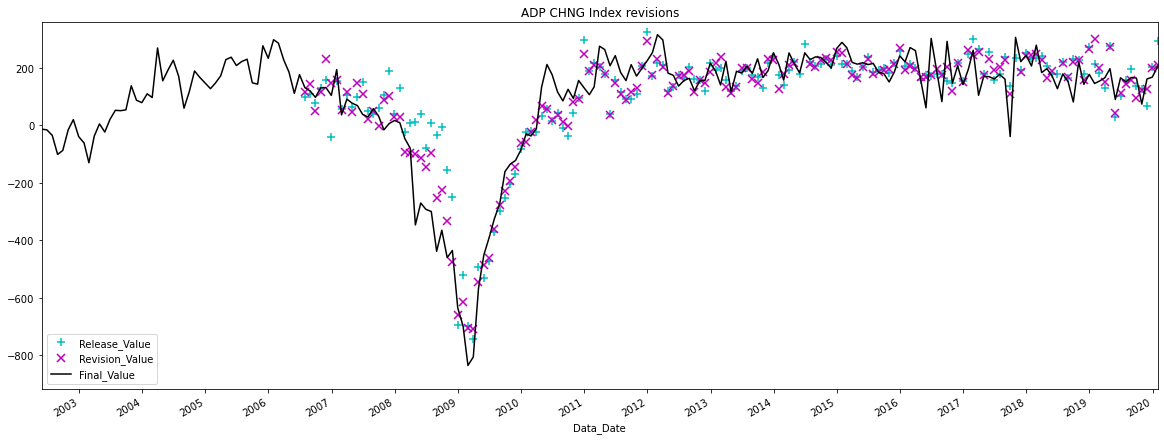

In [20]:
### RUN TO TESTING: FILLED ECO INDICES DATA PLOTTING TO VISUAL CONTROL

### Index choosing:
str_test_index = 'ADP CHNG Index'
### Data loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled)
df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)
### Flags printing:
print(df_flags.loc[str_test_index, All])
### Series creating:
df_eco_ind = df_dates_filled.loc[(str_test_index, All), All].droplevel(0)[['Release_Value', 'Revision_Value', 'Final_Value']]
date_xlim_start = df_eco_ind.index.min()
date_xlim_finish = df_eco_ind.index.max()
#date_xlim_start = datetime(1984, 12, 31)
date_xlim_finish = datetime(2020, 1, 31)
flo_ylim_min = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].min().min()
flo_ylim_max = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].max().max()
tup_ylim = (flo_ylim_min - abs(flo_ylim_min) / 10, flo_ylim_max + abs(flo_ylim_max) / 10)
#ax_eco_ind = df_eco_ind.plot(figsize = (11, 2), title = str_test_index + ' revisions',                              
ax_eco_ind = df_eco_ind.plot(figsize = (20, 7.5), title = str_test_index + ' revisions', 
                style = ['c+', 'mx', 'k-'], markersize = 7.5, markeredgewidth = 1.5, 
                xlim = (date_xlim_start, date_xlim_finish), ylim = tup_ylim, x_compat = True)
ax_eco_ind.xaxis.set_major_locator(mdates.YearLocator(base = 1))                             
ax_eco_ind.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))                
plt.show() 

Type_Prime                                                   EMP
Type_Second                                                  Emp
Category                                              Coincident
Region                                                        US
Processing                                                  Flow
Base                                                          -1
SA_Status                                                Unclear
Frequency                                                Monthly
Negative                                                       0
Description    ADP National Employment Report Private Nonfarm...
Data_Source                       Automatic Data Processing, Inc
Notes          This indicator measures the number of employee...
Sub_Type                                                     Emp
Name: ADP CHNG Index, dtype: object


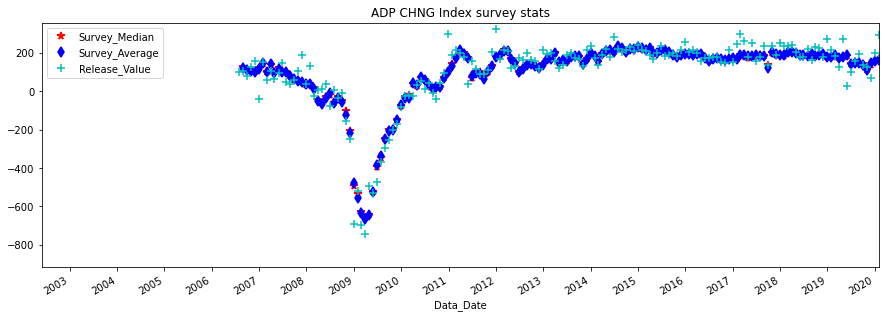

In [21]:
### RUN TO TESTING: FILLED ECO INDICES DATA PLOTTING TO VISUAL CONTROL ### CELL TO ADD

### Index choosing:
str_test_index = 'ADP CHNG Index'
### Data loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled)
df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)
#### Flags printing:
print(df_flags.loc[str_test_index, All])
### Series creating:
if ((len(df_dates_filled.loc[(str_test_index, All), 'Survey_Median'].dropna()) == 0) & 
    (len(df_dates_filled.loc[(str_test_index, All), 'Survey_Average'].dropna()) == 0)):
    print('NO SURVEY DATA HERE!')
df_eco_ind = df_dates_filled.loc[(str_test_index, All), All].droplevel(0)[['Survey_Median', 'Survey_Average', 'Release_Value', 'Revision_Value', 'Final_Value']]    
date_xlim_start = df_eco_ind.index.min()
date_xlim_finish = df_eco_ind.index.max()
#date_xlim_start = datetime(1984, 12, 31)
date_xlim_finish = datetime(2020, 1, 31)
#date_xlim_finish = datetime(2020, 8, 31)
flo_ylim_min = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].min().min()
flo_ylim_max = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].max().max()
tup_ylim = (flo_ylim_min - abs(flo_ylim_min) / 10, flo_ylim_max + abs(flo_ylim_max) / 10)
ax_eco_ind = df_eco_ind[['Survey_Median', 'Survey_Average', 'Release_Value']].plot(figsize = (15, 5), title = str_test_index + ' survey stats', 
                style = ['r*', 'bd', 'c+'], markersize = 7.5, markeredgewidth = 1.5, 
                xlim = (date_xlim_start, date_xlim_finish), ylim = tup_ylim, x_compat = True)
ax_eco_ind.xaxis.set_major_locator(mdates.YearLocator(base = 1))                             
ax_eco_ind.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))                
plt.show()
#ax_eco_ind = df_eco_ind.plot(figsize = (20, 5), title = str_test_index + ' revisions', 
#                style = ['r*', 'bd', 'c+', 'mx', 'k-'], markersize = 7.5, markeredgewidth = 1.5,                              
#                xlim = (date_xlim_start, date_xlim_finish), ylim = tup_ylim, x_compat = True)
#ax_eco_ind.xaxis.set_major_locator(mdates.YearLocator(base = 1))                             
#ax_eco_ind.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))                
#plt.show() 

In [22]:
### RUN TO RE-EXPORT DATA: VALUES STACKING

### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled)
### Release pair stacking:
df_release_pair = df_dates_filled[['Release_Date', 'Release_Value']]
df_release_pair.columns = ['Observation_Date', 'Index_Value']
df_release_pair = df_release_pair.dropna()
ser_release_based = df_release_pair.set_index('Observation_Date', append = True).squeeze()
#df_release_pair['Stage'] = 'Release'
#ser_release_based = df_release_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### First revision pair stacking:
df_revision_pair = df_dates_filled[['Revision_Date', 'Revision_Value']]
df_revision_pair.columns = ['Observation_Date', 'Index_Value']
df_revision_pair = df_revision_pair.dropna()
ser_revision_based = df_revision_pair.set_index('Observation_Date', append = True).squeeze()
#df_revision_pair['Stage'] = 'First Revision'
#ser_revision_based = df_revision_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### Final revision pair stacking:
df_final_pair = df_dates_filled[['Final_Date', 'Final_Value']]
df_final_pair.columns = ['Observation_Date', 'Index_Value']
df_final_pair = df_final_pair.dropna()
ser_final_based = df_final_pair.set_index('Observation_Date', append = True).squeeze()
#df_final_pair['Stage'] = 'Final Revision'
#ser_final_based = df_final_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### Vectors aggregating:
ser_history_raw = ser_final_based.combine_first(ser_revision_based).combine_first(ser_release_based).dropna().sort_index()

In [23]:
### RUN TO RE-EXPORT DATA: FREQUENCY RECREATING

### 84 : BAKETOT Index frequency recreating:
ser_history_raw.loc['BAKETOT Index', pd.to_datetime('1994-12-23'), pd.to_datetime('1994-12-23')] = np.NaN
ser_history_raw.loc['BAKETOT Index', pd.to_datetime('1995-12-22'), pd.to_datetime('1995-12-22')] = np.NaN
### 85 : IEIPIMOM Index frequency recreating:
ser_history_raw.loc['IEIPIMOM Index', pd.to_datetime('2004-08-31'), pd.to_datetime('2004-08-31')] = np.NaN
### 86 : IERSVMOM Index frequency recreating:
ser_history_raw.loc['IERSVMOM Index', pd.to_datetime('2001-01-31'), pd.to_datetime('2001-01-31')] = np.NaN
ser_history_raw.loc['IERSVMOM Index', pd.to_datetime('2001-02-28'), pd.to_datetime('2001-02-28')] = np.NaN
### 87 : ITBCI Index frequency recreating:
ser_history_raw.loc['ITBCI Index', pd.to_datetime('2020-04-30'), pd.to_datetime('2020-04-30')] = np.NaN
### 88 : ITPSSA Index frequency recreating:
ser_history_raw.loc['ITPSSA Index', pd.to_datetime('2020-04-30'), pd.to_datetime('2020-04-30')] = np.NaN
### 89 : JCOMHCF Index frequency recreating:
idx_ticker_date = ser_history_raw.loc[['JCOMHCF Index'], All, All].index.get_level_values('Data_Date').unique()
idx_ticker_date = pd.date_range(start = '1984-12-31', end = '2004-03-31', freq = 'M').difference(idx_ticker_date)
idx_ticker_reindex = pd.MultiIndex.from_tuples(tuple(zip(['JCOMHCF Index'] * len(idx_ticker_date), idx_ticker_date, idx_ticker_date)))
ser_ei_to_add = pd.Series(np.NaN, index = idx_ticker_reindex)
ser_ei_to_add.index.names = ser_history_raw.index.names
ser_history_raw = pd.concat([ser_history_raw, ser_ei_to_add], axis = 0)
### 90 : JNPIY Index frequency rerceating:
ser_history_raw.loc['JNPIY Index', pd.to_datetime('2001-02-28'), pd.to_datetime('2001-02-28')] = np.NaN
### 91 : MAPMINDX Index frequency recreating:
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-05-31'), pd.to_datetime('2016-05-31')] = np.NaN
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-06-30'), pd.to_datetime('2016-06-30')] = np.NaN
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-07-31'), pd.to_datetime('2016-07-31')] = np.NaN
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-08-31'), pd.to_datetime('2016-08-31')] = np.NaN
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-09-30'), pd.to_datetime('2016-09-30')] = np.NaN
### 92 : MPMIGBMA Index frequency recreating:
idx_ticker_date = pd.date_range(start = '2014-01-31', end = '2015-11-30', freq = 'M')
idx_ticker_reindex = pd.MultiIndex.from_tuples(tuple(zip(['MPMIGBMA Index'] * len(idx_ticker_date), idx_ticker_date, idx_ticker_date)))
ser_ei_to_add = pd.Series(np.NaN, index = idx_ticker_reindex)
ser_ei_to_add.index.names = ser_history_raw.index.names
ser_history_raw = pd.concat([ser_history_raw, ser_ei_to_add], axis = 0)
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2012-05-31'), pd.to_datetime('2012-05-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2013-02-28'), pd.to_datetime('2013-02-28')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-01-31'), pd.to_datetime('2016-01-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-02-29'), pd.to_datetime('2016-02-29')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-06-30'), pd.to_datetime('2016-06-30')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-07-31'), pd.to_datetime('2016-07-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-08-31'), pd.to_datetime('2016-08-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-12-31'), pd.to_datetime('2016-12-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2017-03-31'), pd.to_datetime('2017-03-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2017-04-30'), pd.to_datetime('2017-04-30')] = np.NaN
### 93 : NEISIYOY Index frequency recreating:
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('1999-07-31'), pd.to_datetime('1999-07-31')] = np.NaN
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('1999-08-31'), pd.to_datetime('1999-08-31')] = np.NaN
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('2000-06-30'), pd.to_datetime('2000-06-30')] = np.NaN
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('2000-07-31'), pd.to_datetime('2000-07-31')] = np.NaN
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('2000-09-30'), pd.to_datetime('2000-09-30')] = np.NaN
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('2000-11-30'), pd.to_datetime('2000-11-30')] = np.NaN
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('2001-07-31'), pd.to_datetime('2001-07-31')] = np.NaN
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('2002-07-31'), pd.to_datetime('2002-07-31')] = np.NaN
ser_history_raw.loc['NEISIYOY Index', pd.to_datetime('2003-07-31'), pd.to_datetime('2003-07-31')] = np.NaN
### 94 : NERS20Y Index frequency recreating:
ser_history_raw.loc['NERS20Y Index', pd.to_datetime('2001-07-31'), pd.to_datetime('2001-07-31')] = np.NaN
### 95 : PTCCI Index frequency recreating:
ser_history_raw.loc['PTCCI Index', pd.to_datetime('2004-05-31'), pd.to_datetime('2004-05-31')] = np.NaN
### 96 : PTCPHAMM Index frequency recreating:
ser_history_raw.loc['PTCPHAMM Index', pd.to_datetime('2019-01-31'), pd.to_datetime('2019-01-31')] = np.NaN
### 97 : UKCCI Index frequency recreating:
ser_history_raw.loc['UKCCI Index', pd.to_datetime('1995-05-31'), pd.to_datetime('1995-05-31')] = np.NaN
### 98 - 108 : Dropped to keep only one represantative from country in the particular group:
ser_history_raw.drop(['ITISTSAM Index', 'NEISIYOY Index', 'PTISTOTM Index', 'SLIPTIYY Index', 'SPIOWAYY Index', 'IERSVMOM Index', 'ITNSSTN Index', 'SPRSRAY Index',
                      'IEUELV Index', 'IEUEMOM Index', 'SLWIIYOY Index'], level = 'Index_Name', inplace = True)
### 109 - 123 : Dropped due to weak correlation with other particular group members:
ser_history_raw.drop(['SKCCCONC Index', 'GRZEEUEX Index', 'IEIPIMOM Index', 'IEPPIEUM Index', 'MTEF4C Index', 'JNVHSYOY Index', 'JNBTCASE Index', 'JNLSUCTL Index',
                      'HPIMMOM% Index', 'CICRTOT Index', 'PXFECHNG Index', 'UKMSB3PS Index', 'UKAWXTOM Index', 'ITNHMOM Index', 'SVAWRYOY Index'], 
                     level = 'Index_Name', inplace = True)
### Index sorting:
ser_history_raw = ser_history_raw.sort_index()
### Results saving:
ser_history_raw.to_hdf(str_path_bb_fcast_hdf, key = str_key_raw_history, mode = 'a')

In [24]:
### RUN TO TESTING: FREQUENCY CONTROL

ser_history_raw = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_history)
ser_idx_test = ser_history_raw.to_frame().reset_index('Data_Date')['Data_Date'].squeeze().reset_index('Observation_Date', drop = True)
ser_idx_test = ser_idx_test.groupby('Index_Name', group_keys = False).apply(lambda ser_ticker: ser_ticker.drop_duplicates())
df_idx_test = ser_idx_test.groupby('Index_Name').apply(lambda ser_ticker: (ser_ticker - ser_ticker.shift()).dt.days).groupby('Index_Name')\
                                                .agg(['min', 'max', 'median'])
df_idx_test['delta'] = df_idx_test['max'] - df_idx_test['min']
df_idx_test.sort_values('delta')

,min,max,median,delta
Index_Name,,,,
INJCSP Index,7.0,7.0,7.0,0.0
COMFCOMF Index,7.0,7.0,7.0,0.0
BAKETOT Index,7.0,7.0,7.0,0.0
INJCJC Index,7.0,7.0,7.0,0.0
GDP CQOQ Index,90.0,92.0,91.0,2.0
...,...,...,...,...
IECPEUIQ Index,28.0,31.0,31.0,3.0
IECPIMOM Index,28.0,31.0,31.0,3.0
IECSINDX Index,28.0,31.0,31.0,3.0


In [25]:
### RUN TO RE-EXPORT DATA: HISTORY REINDEXATION TO OBSERVATION DATE BUSINESS DAILY MATRIX STRUCTURE (PRELIMINARY ACTIONS)

### Data loading:
ser_history_raw = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_history)
### Moving all dates to tne nearest Business day:
df_history_raw = ser_history_raw.to_frame().reset_index('Observation_Date')
df_history_raw['Observation_Date'] = df_history_raw['Observation_Date'] + 0 * pd.offsets.BDay()
ser_history_bday = df_history_raw.set_index('Observation_Date', append = True).squeeze()
ser_history_bday = ser_history_bday.loc[All, All, idx_date_range]
### Data adding to hdf collection:
ser_history_bday.to_hdf(str_path_bb_fcast_hdf, key = str_key_bday_history, mode = 'a') ### BDay moved observation dates

In [26]:
### RUN TO RE-EXPORT DATA: GROUPING RESEARCH TO SELECT BASIS TICKERS

### Defining minimum Data Date for each ticker:
ser_history_bday = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_bday_history)
ser_min_date = ser_history_bday.to_frame().reset_index('Data_Date').drop(0, axis = 1).reset_index('Observation_Date', drop = True).squeeze().groupby('Index_Name')\
                                                                                                                                            .agg(min)
ser_min_date.name = 'Min_Date'
ser_max_date = ser_history_bday.to_frame().reset_index('Data_Date').drop(0, axis = 1).reset_index('Observation_Date', drop = True).squeeze().groupby('Index_Name')\
                                                                                                                                            .agg(max)
ser_max_date.name = 'Max_Date'
### Creating description table for all types combinations:
df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)
### Defining description table generator:
def type_analyzer(df_group):
    ### Type tickers distribution by region calculating:
    ser_cat_distribution = df_group.groupby('Category').apply(lambda df_category: len(df_category.index))
    ser_cat_distribution['All'] = len(df_group.index)
    ser_cat_distribution = pd.concat([ser_cat_distribution], keys = ['Categories_Distrib'], names = ['Info'])
    ### Adding information about basis ticker for each type:
    ser_cat_distribution['Basic_Ticker_Info', 'Basic_Name'] = df_group['Min_Date'].idxmin()
    ser_cat_distribution['Basic_Ticker_Info', 'Category'] = df_group.loc[df_group['Min_Date'].idxmin(), 'Category']
    ser_cat_distribution['Basic_Ticker_Info', 'Min_Date'] = df_group.loc[df_group['Min_Date'].idxmin(), 'Min_Date']    
    ser_cat_distribution['Basic_Ticker_Info', 'Description'] = df_group.loc[df_group['Min_Date'].idxmin(), 'Description']     
    ### Results output:
    return ser_cat_distribution
### Extending flags table and dropping tickers, that were cleared earlier:
df_flags_typed = pd.concat([df_flags, ser_min_date, ser_max_date], axis = 1, sort = False)
df_flags_typed = df_flags_typed.loc[df_flags_typed['Min_Date'].notna()]
### Description table generating:
df_type_info = df_flags_typed.groupby(['Type_Prime', 'Sub_Type', 'Region']).apply(type_analyzer)
df_type_info = df_type_info.unstack(['Info', 'Category'], fill_value = 0)
df_type_info.columns.names = ['', '']
df_type_info = df_type_info.sort_index(axis = 1)
### Description table editing to choose proper basic tickers in some cases:
df_type_info.loc[('ANT', 'Bus', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['EUBCI Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('ANT', 'Bus', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['NAPMPMI Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('ANT', 'Cons', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['EUCCEMU Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('EMP', 'Emp', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['USURTOT Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('OUT', 'Orders', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['TMNOCHNG Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('OUT', 'Prod', 'Japan'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['JNIPMOM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info[('Basic_Ticker_Info', 'Min_Date')] = pd.to_datetime(df_type_info[('Basic_Ticker_Info', 'Min_Date')])
### Description table additional editing to optimize groups:
df_type_info.loc[('ANT', 'Bus', 'UK'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['ITSR1B Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('CON', 'Cons', 'Japan'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['JNDSTYOY Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('CON', 'Cons', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['PITLCHNG Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('EMP', 'Emp', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['UMRTEMU Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('EMP', 'Emp', 'UK'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['UKUEMOM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('INF', 'CPI', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['ECCPEMUM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('INF', 'CPI', 'UK'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['UKRPXYOY Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('INF', 'CPI', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['PCE CMOM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('OUT', 'Orders', 'Japan'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['JNMOCHNG Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('OUT', 'Prod', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['EUITEMUM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
## Binding each ticker with it's basis:
df_basic_ticker = df_type_info[[('Basic_Ticker_Info', 'Basic_Name'), ('Basic_Ticker_Info', 'Min_Date')]]
df_basic_ticker.columns = ['Basic_Ticker', 'Basic_Min_Date']
df_flags_typed = df_flags_typed.join(df_basic_ticker, how = 'left', on = ['Type_Prime', 'Sub_Type', 'Region'])
### Clearing basic ticker for basic tickers and resort values to guarantee basic tickers priority:
df_flags_typed.loc[df_flags_typed.index == df_flags_typed['Basic_Ticker'], 'Basic_Ticker'] = ''
df_flags_typed = df_flags_typed.groupby('Basic_Ticker', group_keys = False).apply(lambda df_group: df_group.sort_index())
### Adding flag to define if we need to rebase ticker:
df_flags_typed['Rebase_Flag'] = True
df_flags_typed.loc[df_flags_typed['Basic_Ticker'] == '', 'Rebase_Flag'] = False
df_flags_typed.loc[df_flags_typed['Min_Date'] < (datetime_basis - pd.DateOffset(years = int_not_to_rebase_term)), 'Rebase_Flag'] = False
df_flags_typed.loc[df_flags_typed['Min_Date'] < (df_flags_typed['Basic_Min_Date'] + pd.DateOffset(years = int_not_to_rebase_diff)), 'Rebase_Flag'] = False
### Columns reordering and filtering:
df_flags_typed = df_flags_typed[['Type_Prime', 'Sub_Type', 'Region', 'Category', 'Min_Date', 'Max_Date', 'Frequency', 'Processing', 'Base', 'SA_Status', 'Negative',
                                 'Rebase_Flag', 'Basic_Ticker', 'Description', 'Data_Source', 'Notes']]
df_flags_typed.index.names = ['Index_Name']
### Results saving:
df_type_info.to_hdf(str_path_bb_fcast_hdf, key = str_key_types_info, mode = 'a')
df_flags_typed.to_hdf(str_path_bb_fcast_hdf, key = str_key_flags_typed, mode = 'a')
#df_type_info.to_excel('Data_Files/Test_Files/Ticker_Info.xlsx', merge_cells = False)
#df_flags_typed.to_excel('Data_Files/Test_Files/Ticker_Info.xlsx', merge_cells = False)

In [ ]:
### RUN TO RE-EXPORT DATA: HISTORY DATA TRANSFORMATION (ANTICIPATION ONLY)

gc.collect()
### Defining parallelized transform for groupby groups:
def transformParallel(serGrouped, func):
    retLst = Parallel(n_jobs = 4)(delayed(func)(group) for name, group in serGrouped)    
    return pd.concat(retLst)
### Defining Economic Index series transformation:
def complex_transform(ser_name, idx_date_range, df_flags, int_max_name_length, int_min_years, str_path_bb_matrix_hdf, bool_perform_sa = False):
    ### Defining triangle extraction:
    def triangle_filter(ser_date):
        ### Extracting particular Data Date:
        date_diag = ser_date.index.get_level_values('Data_Date')[0]
        ### Dropping constant level:
        ser_result = ser_date.droplevel('Data_Date')
        ### Filtering over-diagonal values:
        ser_result = ser_result[ser_result.index >= date_diag] 
        ### Results output:
        return ser_result
    ### X13 ARIMA Seasonality adjustment model:
    def perform_x13_sa(ser_date):
        ### Dropping constant level:        
        ser_result = ser_date.droplevel('Observation_Date')
        ### Check for not empty vector:
        if (ser_result.count() > 0):
            ### Check for minimal quantity of observations to perform seasonality adjustment:
            if (ser_result.last_valid_index() - ser_result.first_valid_index()).days >= (int_min_years * 365):   
                ### Naming series for x13 performing:
                ser_result.name = 'Ticker'
                ### Calculating shift value to make all series positive:
                flo_positron = abs(ser_result.min()) * 2
                try:
                    ### Performing seasonality adjustment:
                    ser_result = x13_arima_analysis(ser_result + flo_positron, outlier = True, trading = True).seasadj - flo_positron
#                    print('SA success : ', ser_date.index.get_level_values('Observation_Date')[0])                 
                except:
                    print('SA error : ', ser_date.index.get_level_values('Observation_Date')[0])
                    pass
        ### Results output:                
#        return ser_result 
        return pd.concat([ser_result], keys = [ser_date.index.get_level_values('Observation_Date')[0]], names = ['Observation_Date'])    
    ### Extracting Observation Date column for ticker:
    def get_obs_date_vector(str_ticker, str_path_bb_matrix_hdf, str_date, bool_exact_date = False, bool_drop_levels = True):
        ### Vector for exact date:
        if bool_exact_date:
            ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
        ### Vector for nearest date:        
        else:
            ### Loading full ticker series:        
            ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
            ### Extracting data for max date less or equal to needed date:
            ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
        ### Dropping constant index levels if needed:
        if bool_drop_levels:
            return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
        else:
            return ser_obs_date    
    ### Defining time-vector z-scoring procedure:    
    def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj, 
                        str_path_bb_matrix_hdf, str_basis_index, bool_rebase_flag, list_continue_rebase):
        ### Check for empty vector (doing nothing):
        if ser_date.count():
            ### Check for non-constant vector:
            if (ser_date.std() > flo_tolerance):
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                    ### Calculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                    bool_to_winsor = True   
                    int_iter = 1
                    while (bool_to_winsor): 
                        int_iter += 1                
                        ### Value based winsorization:                
                        ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                        ### Recalculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                        ### Checking for boundaries and steps:
                        if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                            bool_to_winsor = False
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
            else:
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                    ### Constant values demeaning:
                    ser_date = ser_date - ser_date.mean()
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')                    
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
        ### Memory optimization:
        ser_date = ser_date.astype('float32')
        return ser_date    
    ### EI name extracting:
    str_index_name = ser_name.index.get_level_values(0)[0]
    ### Observation dates reindexation:    
    print(ser_name.index.get_level_values(0)[0], ': Reindexation')    
    idx_observation_range = ser_name.index.get_level_values('Observation_Date').unique().intersection(idx_date_range).sort_values()
    ser_full = ser_name.droplevel('Index_Name').unstack('Data_Date').reindex(idx_observation_range).stack('Data_Date', dropna = False).squeeze()
    ser_full = ser_full.swaplevel()
    ser_full.index.rename('Observation_Date', level = -1, inplace = True)    
    ### Forward filling for each data date:
    ser_full = ser_full.groupby('Data_Date').ffill()   
    ### Diagonalization:
    ser_triangle = ser_full.groupby('Data_Date').apply(triangle_filter).sort_index()
    ### Flags extracting:
    ser_flags = df_flags.loc[str_index_name, All].squeeze() 
    ### 'TAR' type checking:
    if (ser_flags['Type_Prime'] == 'TAR'):
        print(str_index_name, ': TAR Primary Type ignoring')        
        pass
    ### Flags-based transforming:
    else:
        ### Indices of NA values collecting:
        idx_isna = ser_triangle.loc[ser_triangle.isna()].index
        ### Transforming to stock-like series:
        ser_stock = ser_triangle
        ### Seasonality adjustment:
        if (bool_perform_sa & (ser_flags['SA_Status'].strip(' ') != 'SA')):
            print(str_index_name, ': Seasonality adjustment')            
            ### Filling empty values:            
            ser_stock = ser_stock.groupby('Observation_Date').ffill()
#            ser_stock = ser_stock.groupby('Observation_Date').apply(perform_x13_sa).swaplevel().sort_index()
            ser_stock = transformParallel(ser_stock.groupby('Observation_Date'), perform_x13_sa).swaplevel().sort_index()       
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN    
        ### Debasing:
        print(str_index_name, ': Debasing')            
        ser_ant = ser_stock - ser_flags['Base']           
        ser_ant.name = 'MoM'
        ### Negative flag check:
        if (ser_flags['Negative'] == 1):
            ser_ant = -ser_ant
        ### Z-scoring across the observation dates:
        print(ser_name.index.get_level_values(0)[0], ': Z-scoring across the observation dates')
        ### To stop rebasing when basic ticker (std, mean) are close to (1, 0):
        list_continue_rebase = [True] 
        ### Adjusting Z-score period limit for some groups:
        if (ser_flags['Data_Source'] == 'Markit'):
            int_min_years_adj = int_min_years - 1
        else:
            int_min_years_adj = int_min_years    
        ### Z-score tranformation:
        ser_ant_z = ser_ant.groupby('Observation_Date')\
                           .transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years_adj,
                                      str_path_bb_matrix_hdf, ser_flags['Basic_Ticker'], ser_flags['Rebase_Flag'], list_continue_rebase)       
        ### Adding results to matrix cube:
        pd.concat([ser_ant_z], keys = [str_index_name], names = ['Index_Name']).to_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, format = 'table',
                                                                                       complevel = 9, append = True, mode = 'a',
                                                                                       min_itemsize = {'Index_Name': int_max_name_length})    
#    ### Results output:
#    return pd.concat([ser_mom_z], keys = [str_index_name], names = ['Index_Name'])

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags_typed)
df_flags_ant = df_flags_typed[(df_flags_typed['Type_Prime'] == 'ANT') & (df_flags_typed['Processing'] == 'Index')]
### Economic Indices vector loading:
ser_history_bday = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_bday_history)
ser_history_ant = ser_history_bday.reindex(df_flags_ant.index, level = 'Index_Name')
### Previous HDF file deleting:
if os.path.isfile(str_path_bb_matrix_ant_hdf):
    os.remove(str_path_bb_matrix_ant_hdf)
### Maximum length calculating (for HDF manipulations):
int_max_name_length = max(ser_history_ant.index.levels[0].str.len())
### Data transforming:
ser_history_ant.groupby('Index_Name').apply(complex_transform, idx_date_range, df_flags_typed, int_max_name_length, int_min_years_z_score, str_path_bb_matrix_ant_hdf,
                                            bool_perform_sa = True)

In [ ]:
### RUN TO RE-EXPORT DATA: HISTORY DATA TRANSFORMATION (YOY ONLY)

### Defining parallelized transform for groupby groups:
def transformParallel(serGrouped, func):
    retLst = Parallel(n_jobs = 4)(delayed(func)(group) for name, group in serGrouped)    
    return pd.concat(retLst)
### Defining Economic Index series transformation:
def complex_transform(ser_name, idx_date_range, df_flags, int_max_name_length, int_min_years, str_path_bb_matrix_hdf, bool_perform_sa = False):
    ### Defining triangle extraction:
    def triangle_filter(ser_date):
        ### Extracting particular Data Date:
        date_diag = ser_date.index.get_level_values('Data_Date')[0]
        ### Dropping constant level:
        ser_result = ser_date.droplevel('Data_Date')
        ### Filtering over-diagonal values:
        ser_result = ser_result[ser_result.index >= date_diag] 
        ### Results output:
        return ser_result
    ### Period-over-period-percent ticker values transforming to stock-like series:
    def pop_to_level(ser_date, int_step):
        ### Dropping constant level:
        ser_result = ser_date.droplevel('Observation_Date')
        ### Basis initiating:
        flo_basement = 1.0
        ### Factor initiating: 
        flo_next_brick  = 1.0
        ### Looping over month numbers:
        for iter_period in range(min(int_step, len(ser_result.index))):         
            ### Basement building up:
            flo_basement = flo_basement * flo_next_brick
            ### Next basement brick producing:
            flo_next_brick = ((flo_next_brick ** (iter_period)) * (ser_result.iloc[iter_period] ** (1 / int_step))) ** (1 / (iter_period + 1)) 
            ### Jumping cumulative product performing:
            idx_iter_data = ser_result.index[iter_period :: int_step]
            ser_result.loc[idx_iter_data] = ser_result.loc[idx_iter_data].cumprod() * flo_basement       
        ### Results output:            
        return ser_result    
    ### X13 ARIMA Seasonality adjustment model:
    def perform_x13_sa(ser_date):
        ### Dropping constant level:        
        ser_result = ser_date.droplevel('Observation_Date')
        ### Check for not empty vector:
        if (ser_result.count() > 0):
            ### Check for minimal quantity of observations to perform seasonality adjustment:
            if (ser_result.last_valid_index() - ser_result.first_valid_index()).days >= (int_min_years * 365):   
                ### Naming series for x13 performing:
                ser_result.name = 'Ticker'
                ### Calculating shift value to make all series positive:
                flo_positron = abs(ser_result.min()) * 2
                try:
                    ### Performing seasonality adjustment:
                    ser_result = x13_arima_analysis(ser_result + flo_positron, outlier = True, trading = True).seasadj - flo_positron
#                    print('SA success : ', ser_date.index.get_level_values('Observation_Date')[0])                 
                except:
                    print('SA error : ', ser_date.index.get_level_values('Observation_Date')[0])
                    pass
        ### Results output:                
#        return ser_result 
        return pd.concat([ser_result], keys = [ser_date.index.get_level_values('Observation_Date')[0]], names = ['Observation_Date'])    
    ### Extracting Observation Date column for ticker:
    def get_obs_date_vector(str_ticker, str_path_bb_matrix_hdf, str_date, bool_exact_date = False, bool_drop_levels = True):
        ### Vector for exact date:
        if bool_exact_date:
            ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
        ### Vector for nearest date:        
        else:
            ### Loading full ticker series:        
            ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
            ### Extracting data for max date less or equal to needed date:
            ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
        ### Dropping constant index levels if needed:
        if bool_drop_levels:
            return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
        else:
            return ser_obs_date    
    ### Defining time-vector z-scoring procedure:    
    def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj, 
                        str_path_bb_matrix_hdf, str_basis_index, bool_rebase_flag, list_continue_rebase):
        ### Check for empty vector (doing nothing):
        if ser_date.count():
            ### Check for non-constant vector:
            if (ser_date.std() > flo_tolerance):
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                    ### Calculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                    bool_to_winsor = True   
                    int_iter = 1
                    while (bool_to_winsor): 
                        int_iter += 1                
                        ### Value based winsorization:                
                        ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                        ### Recalculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                        ### Checking for boundaries and steps:
                        if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                            bool_to_winsor = False
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
            else:
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                    ### Constant values demeaning:
                    ser_date = ser_date - ser_date.mean()
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')                    
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
        ### Memory optimization:
        ser_date = ser_date.astype('float32')
        return ser_date    
    ### EI name extracting:
    str_index_name = ser_name.index.get_level_values(0)[0]
    ### Observation dates reindexation:    
    print(ser_name.index.get_level_values(0)[0], ': Reindexation')    
    idx_observation_range = ser_name.index.get_level_values('Observation_Date').unique().intersection(idx_date_range).sort_values()
    ser_full = ser_name.droplevel('Index_Name').unstack('Data_Date').reindex(idx_observation_range).stack('Data_Date', dropna = False).squeeze()
    ser_full = ser_full.swaplevel()
    ser_full.index.rename('Observation_Date', level = -1, inplace = True)    
    ### Forward filling for each data date:
    ser_full = ser_full.groupby('Data_Date').ffill()   
    ### Diagonalization:
    ser_triangle = ser_full.groupby('Data_Date').apply(triangle_filter).sort_index()
    ### Flags extracting:
    ser_flags = df_flags.loc[str_index_name, All].squeeze() 
    ### 'TAR' type checking:
    if (ser_flags['Type_Prime'] == 'TAR'):
        print(str_index_name, ': TAR Primary Type ignoring')        
        pass
    ### Flags-based transforming:
    else:
        ### Indices of NA values collecting:
        idx_isna = ser_triangle.loc[ser_triangle.isna()].index
        ### Transforming to stock-like series:
        if (ser_flags['Processing'] in ['Index', 'Level', 'Level%']):
            ser_stock = ser_triangle
        elif (ser_flags['Processing'] == 'Flow'):
            print(str_index_name, ': Transformation to stock-like series: Cumulative sum')
            ### Filling empty values:
            ser_triangle = ser_triangle.fillna(0)
            ### Cumulative sum for each observation date calculating:
            ser_stock = ser_triangle.groupby('Observation_Date').cumsum()
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN
        else:
            print(str_index_name, ': Transformation to stock-like series: Cumulative product')
            ### Filling empty values:
            ser_triangle = ser_triangle.fillna(0)
            ### Percents to multipliers converting:
            ser_stock = 1 + ser_triangle / 100
            ### Calculating with needed periodicity:
            if (ser_flags['Frequency'] == 'Monthly'):
                int_step = dict_cumprod_step[ser_flags['Processing']]
                ### Period-by-period cumprod with rebasing:
                ser_stock = ser_stock.groupby('Observation_Date').apply(pop_to_level, int_step).swaplevel().sort_index()
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN
        ### Seasonality adjustment:
        if (bool_perform_sa & (ser_flags['SA_Status'].strip(' ') != 'SA')):
            print(str_index_name, ': Seasonality adjustment')            
            ### Filling empty values:            
            ser_stock = ser_stock.groupby('Observation_Date').ffill()
#            ser_stock = ser_stock.groupby('Observation_Date').apply(perform_x13_sa).swaplevel().sort_index()
            ser_stock = transformParallel(ser_stock.groupby('Observation_Date'), perform_x13_sa).swaplevel().sort_index()       
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN    
        ### Transforming to PoP series:
        if (ser_flags['Processing'] == 'Index'):
            ### Debasing only:
            print(str_index_name, ': Transformation to YoY series: Debasing')            
            ser_ant = ser_stock - ser_flags['Base']           
        elif (ser_flags['Processing'] in ['Flow', 'Level']):    
            ### Simple difference:
            print(str_index_name, ': Transformation to YoY series: Simple difference')
            ### Shifting lag defining:
            if (ser_flags['Frequency'] in dict_yoy_shift.keys()):
                int_yoy_shift = dict_yoy_shift[ser_flags['Frequency']]
            else:
                int_yoy_shift = dict_yoy_shift['Other']            
            ### Stock-like series differing:
            ser_yoy = ser_stock.groupby('Observation_Date', group_keys = False).apply(lambda ser_obs_date: ser_obs_date - ser_obs_date.shift(int_yoy_shift))
        else:      
            ### Difference with dividing:
            print(str_index_name, ': Transformation to YoY series: Difference with dividing')
            ### Shifting lag defining:
            if (ser_flags['Frequency'] in dict_yoy_shift.keys()):
                int_yoy_shift = dict_yoy_shift[ser_flags['Frequency']]
            else:
                int_yoy_shift = dict_yoy_shift['Other']
            ### Stock-like series differing:
            ser_yoy = ser_stock.groupby('Observation_Date', group_keys = False)\
                               .apply(lambda ser_obs_date: (ser_obs_date / ser_obs_date.shift(int_yoy_shift) - 1))  
        ser_yoy.name = 'YoY'
        ### Negative flag check:
        if (ser_flags['Negative'] == 1):
            ser_yoy = -ser_yoy
        ### Z-scoring across the observation dates:
        print(ser_name.index.get_level_values(0)[0], ': Z-scoring across the observation dates')
        ### To stop rebasing when basic ticker (std, mean) are close to (1, 0):
        list_continue_rebase = [True] 
        ### Adjusting Z-score period limit for some groups:
        if (ser_flags['Data_Source'] == 'Markit'):
            int_min_years_adj = int_min_years - 1
        else:
            int_min_years_adj = int_min_years    
        ### Z-score tranformation:
        ser_yoy_z = ser_yoy.groupby('Observation_Date')\
                           .transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years_adj,
                                      str_path_bb_matrix_hdf, ser_flags['Basic_Ticker'], ser_flags['Rebase_Flag'], list_continue_rebase)       
#        ser_yoy_z = transformParallel(ser_yoy.groupby('Observation_Date'), by_date_z_score_to_parallel).sort_index() ### Parallelization attempt
        ### Adding results to matrix cube:
        pd.concat([ser_yoy_z], keys = [str_index_name], names = ['Index_Name']).to_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, format = 'table',
                                                                                       complevel = 9, append = True, mode = 'a',
                                                                                       min_itemsize = {'Index_Name': int_max_name_length})    
#    ### Results output:
#    return pd.concat([ser_yoy_z], keys = [str_index_name], names = ['Index_Name'])

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags_typed)
df_flags_other = df_flags_typed[(df_flags_typed['Type_Prime'] != 'ANT') & (df_flags_typed['Processing'] != 'Index')]
### Economic Indices vector loading:
ser_history_bday = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_bday_history)
ser_history_other = ser_history_bday.reindex(df_flags_other.index, level = 'Index_Name')#.loc[['GRFRIAMM Index', 'ITVHYOY Index', 'NERS20Y Index'], All, All]
### Previous HDF file deleting:
if os.path.isfile(str_path_bb_matrix_yoy_hdf):
    os.remove(str_path_bb_matrix_yoy_hdf)
### Maximum length calculating (for HDF manipulations):
int_max_name_length = max(ser_history_other.index.levels[0].str.len())
### Data transforming:
ser_history_other.groupby('Index_Name').apply(complex_transform, idx_date_range, df_flags_typed, int_max_name_length, int_min_years_z_score, 
                                              str_path_bb_matrix_yoy_hdf, bool_perform_sa = True)

In [27]:
### RUN TO RE-EXPORT DATA: REPLACING RELEASE VALUES WITH SURVEY MEDIANS TO NORMALIZE SURVEY MEDIAN BY MATRIX STRUCTURE TRANSFORMATION ### CELL TO ADD

### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled)
### Data loading:
ser_history_survey = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_history)
### 98 - 108 : Dropped to keep only one representative from country in the particular group:
df_dates_filled.drop(['ITISTSAM Index', 'NEISIYOY Index', 'PTISTOTM Index', 'SLIPTIYY Index', 'SPIOWAYY Index', 'IERSVMOM Index', 'ITNSSTN Index', 'SPRSRAY Index',
                      'IEUELV Index', 'IEUEMOM Index', 'SLWIIYOY Index'], level = 'Index_Name', inplace = True)
### 109 - 123 : Dropped due to weak correlation with other particular group members:
df_dates_filled.drop(['SKCCCONC Index', 'GRZEEUEX Index', 'IEIPIMOM Index', 'IEPPIEUM Index', 'MTEF4C Index', 'JNVHSYOY Index', 'JNBTCASE Index', 'JNLSUCTL Index',
                      'HPIMMOM% Index', 'CICRTOT Index', 'PXFECHNG Index', 'UKMSB3PS Index', 'UKAWXTOM Index', 'ITNHMOM Index', 'SVAWRYOY Index'], 
                     level = 'Index_Name', inplace = True)
### Release pair stacking:
df_release_pair = df_dates_filled[['Release_Date', 'Release_Value']]
df_release_pair.columns = ['Observation_Date', 'Release_Value']
df_release_pair = df_release_pair.dropna()
ser_release_based = df_release_pair.set_index('Observation_Date', append = True).squeeze()

### Survey pair stacking:
df_survey_pair = df_dates_filled[['Release_Date', 'Survey_Median']]
df_survey_pair.columns = ['Observation_Date', 'Index_Value']
df_survey_pair = df_survey_pair.dropna()
ser_survey_based = df_survey_pair.set_index('Observation_Date', append = True).squeeze()
idx_survey_indices = ser_survey_based.index.get_level_values('Index_Name').unique()
ser_survey_based = ser_release_based.to_frame().join(ser_survey_based, how = 'left')['Index_Value']

ser_history_survey.loc[ser_survey_based.index] = ser_survey_based.values
ser_history_survey = ser_history_survey.loc[idx_survey_indices]

ser_history_survey.to_hdf(str_path_bb_fcast_hdf, key = str_key_survey_history, mode = 'a')

In [ ]:
### RUN TO RE-EXPORT DATA: HISTORY DATA TRANSFORMATION (ANTICIPATION ONLY)

gc.collect()
### Defining parallelized transform for groupby groups:
def transformParallel(serGrouped, func):
    retLst = Parallel(n_jobs = 4)(delayed(func)(group) for name, group in serGrouped)    
    return pd.concat(retLst)
### Defining Economic Index series transformation:
def complex_transform(ser_name, idx_date_range, df_flags, int_max_name_length, int_min_years, str_path_bb_matrix_hdf, bool_perform_sa = False):
    ### Defining triangle extraction:
    def triangle_filter(ser_date):
        ### Extracting particular Data Date:
        date_diag = ser_date.index.get_level_values('Data_Date')[0]
        ### Dropping constant level:
        ser_result = ser_date.droplevel('Data_Date')
        ### Filtering over-diagonal values:
        ser_result = ser_result[ser_result.index >= date_diag] 
        ### Results output:
        return ser_result
    ### X13 ARIMA Seasonality adjustment model:
    def perform_x13_sa(ser_date):
        ### Dropping constant level:        
        ser_result = ser_date.droplevel('Observation_Date')
        ### Check for not empty vector:
        if (ser_result.count() > 0):
            ### Check for minimal quantity of observations to perform seasonality adjustment:
            if (ser_result.last_valid_index() - ser_result.first_valid_index()).days >= (int_min_years * 365):   
                ### Naming series for x13 performing:
                ser_result.name = 'Ticker'
                ### Calculating shift value to make all series positive:
                flo_positron = abs(ser_result.min()) * 2
                try:
                    ### Performing seasonality adjustment:
                    ser_result = x13_arima_analysis(ser_result + flo_positron, outlier = True, trading = True).seasadj - flo_positron
#                    print('SA success : ', ser_date.index.get_level_values('Observation_Date')[0])                 
                except:
                    print('SA error : ', ser_date.index.get_level_values('Observation_Date')[0])
                    pass
        ### Results output:                
#        return ser_result 
        return pd.concat([ser_result], keys = [ser_date.index.get_level_values('Observation_Date')[0]], names = ['Observation_Date'])    
    ### Extracting Observation Date column for ticker:
    def get_obs_date_vector(str_ticker, str_path_bb_matrix_hdf, str_date, bool_exact_date = False, bool_drop_levels = True):
        ### Vector for exact date:
        if bool_exact_date:
            ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
        ### Vector for nearest date:        
        else:
            ### Loading full ticker series:        
            ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
            ### Extracting data for max date less or equal to needed date:
            ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
        ### Dropping constant index levels if needed:
        if bool_drop_levels:
            return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
        else:
            return ser_obs_date    
    ### Defining time-vector z-scoring procedure:    
    def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj, 
                        str_path_bb_matrix_hdf, str_basis_index, bool_rebase_flag, list_continue_rebase):
        ### Check for empty vector (doing nothing):
        if ser_date.count():
            ### Check for non-constant vector:
            if (ser_date.std() > flo_tolerance):
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                    ### Calculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                    bool_to_winsor = True   
                    int_iter = 1
                    while (bool_to_winsor): 
                        int_iter += 1                
                        ### Value based winsorization:                
                        ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                        ### Recalculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                        ### Checking for boundaries and steps:
                        if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                            bool_to_winsor = False
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
            else:
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                    ### Constant values demeaning:
                    ser_date = ser_date - ser_date.mean()
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')                    
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
        ### Memory optimization:
        ser_date = ser_date.astype('float32')
        return ser_date    
    ### EI name extracting:
    str_index_name = ser_name.index.get_level_values(0)[0]
    ### Observation dates reindexation:    
    print(ser_name.index.get_level_values(0)[0], ': Reindexation')    
    idx_observation_range = ser_name.index.get_level_values('Observation_Date').unique().intersection(idx_date_range).sort_values()
    ser_full = ser_name.droplevel('Index_Name').unstack('Data_Date').reindex(idx_observation_range).stack('Data_Date', dropna = False).squeeze()
    ser_full = ser_full.swaplevel()
    ser_full.index.rename('Observation_Date', level = -1, inplace = True)    
    ### Forward filling for each data date:
    ser_full = ser_full.groupby('Data_Date').ffill()   
    ### Diagonalization:
    ser_triangle = ser_full.groupby('Data_Date').apply(triangle_filter).sort_index()
    ### Flags extracting:
    ser_flags = df_flags.loc[str_index_name, All].squeeze() 
    ### 'TAR' type checking:
    if (ser_flags['Type_Prime'] == 'TAR'):
        print(str_index_name, ': TAR Primary Type ignoring')        
        pass
    ### Flags-based transforming:
    else:
        ### Indices of NA values collecting:
        idx_isna = ser_triangle.loc[ser_triangle.isna()].index
        ### Transforming to stock-like series:
        ser_stock = ser_triangle
        ### Seasonality adjustment:
        if (bool_perform_sa & (ser_flags['SA_Status'].strip(' ') != 'SA')):
            print(str_index_name, ': Seasonality adjustment')            
            ### Filling empty values:            
            ser_stock = ser_stock.groupby('Observation_Date').ffill()
#            ser_stock = ser_stock.groupby('Observation_Date').apply(perform_x13_sa).swaplevel().sort_index()
            ser_stock = transformParallel(ser_stock.groupby('Observation_Date'), perform_x13_sa).swaplevel().sort_index()       
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN    
        ### Debasing:
        print(str_index_name, ': Debasing')            
        ser_ant = ser_stock - ser_flags['Base']           
        ser_ant.name = 'MoM'
        ### Negative flag check:
        if (ser_flags['Negative'] == 1):
            ser_ant = -ser_ant
        ### Z-scoring across the observation dates:
        print(ser_name.index.get_level_values(0)[0], ': Z-scoring across the observation dates')
        ### To stop rebasing when basic ticker (std, mean) are close to (1, 0):
        list_continue_rebase = [True] 
        ### Adjusting Z-score period limit for some groups:
        if (ser_flags['Data_Source'] == 'Markit'):
            int_min_years_adj = int_min_years - 1
        else:
            int_min_years_adj = int_min_years    
        ### Z-score tranformation:
        ser_ant_z = ser_ant.groupby('Observation_Date')\
                           .transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years_adj,
                                      str_path_bb_matrix_hdf, ser_flags['Basic_Ticker'], ser_flags['Rebase_Flag'], list_continue_rebase)       
        ### Adding results to matrix cube:
        pd.concat([ser_ant_z], keys = [str_index_name], names = ['Index_Name']).to_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, format = 'table',
                                                                                       complevel = 9, append = True, mode = 'a',
                                                                                       min_itemsize = {'Index_Name': int_max_name_length})    
#    ### Results output:
#    return pd.concat([ser_mom_z], keys = [str_index_name], names = ['Index_Name'])

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags_typed)
df_flags_ant = df_flags_typed[(df_flags_typed['Type_Prime'] == 'ANT') & (df_flags_typed['Processing'] == 'Index')]
### Economic Indices vector loading:
ser_history_bday = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_survey_history)
ser_history_ant = ser_history_bday.reindex(df_flags_ant.index, level = 'Index_Name')
### Previous HDF file deleting:
if os.path.isfile(str_path_survey_matrix_ant_hdf):
    os.remove(str_path_survey_matrix_ant_hdf)
### Maximum length calculating (for HDF manipulations):
int_max_name_length = max(ser_history_ant.index.levels[0].str.len())
### Data transforming:
ser_history_ant.groupby('Index_Name').apply(complex_transform, idx_date_range, df_flags_typed, int_max_name_length, int_min_years_z_score, 
                                            str_path_survey_matrix_ant_hdf, bool_perform_sa = True)

In [ ]:
### RUN TO RE-EXPORT DATA: HISTORY DATA TRANSFORMATION (YOY ONLY)

### Defining parallelized transform for groupby groups:
def transformParallel(serGrouped, func):
    retLst = Parallel(n_jobs = 4)(delayed(func)(group) for name, group in serGrouped)    
    return pd.concat(retLst)
### Defining Economic Index series transformation:
def complex_transform(ser_name, idx_date_range, df_flags, int_max_name_length, int_min_years, str_path_bb_matrix_hdf, bool_perform_sa = False):
    ### Defining triangle extraction:
    def triangle_filter(ser_date):
        ### Extracting particular Data Date:
        date_diag = ser_date.index.get_level_values('Data_Date')[0]
        ### Dropping constant level:
        ser_result = ser_date.droplevel('Data_Date')
        ### Filtering over-diagonal values:
        ser_result = ser_result[ser_result.index >= date_diag] 
        ### Results output:
        return ser_result
    ### Period-over-period-percent ticker values transforming to stock-like series:
    def pop_to_level(ser_date, int_step):
        ### Dropping constant level:
        ser_result = ser_date.droplevel('Observation_Date')
        ### Basis initiating:
        flo_basement = 1.0
        ### Factor initiating: 
        flo_next_brick  = 1.0
        ### Looping over month numbers:
        for iter_period in range(min(int_step, len(ser_result.index))):         
            ### Basement building up:
            flo_basement = flo_basement * flo_next_brick
            ### Next basement brick producing:
            flo_next_brick = ((flo_next_brick ** (iter_period)) * (ser_result.iloc[iter_period] ** (1 / int_step))) ** (1 / (iter_period + 1)) 
            ### Jumping cumulative product performing:
            idx_iter_data = ser_result.index[iter_period :: int_step]
            ser_result.loc[idx_iter_data] = ser_result.loc[idx_iter_data].cumprod() * flo_basement       
        ### Results output:            
        return ser_result    
    ### X13 ARIMA Seasonality adjustment model:
    def perform_x13_sa(ser_date):
        ### Dropping constant level:        
        ser_result = ser_date.droplevel('Observation_Date')
        ### Check for not empty vector:
        if (ser_result.count() > 0):
            ### Check for minimal quantity of observations to perform seasonality adjustment:
            if (ser_result.last_valid_index() - ser_result.first_valid_index()).days >= (int_min_years * 365):   
                ### Naming series for x13 performing:
                ser_result.name = 'Ticker'
                ### Calculating shift value to make all series positive:
                flo_positron = abs(ser_result.min()) * 2
                try:
                    ### Performing seasonality adjustment:
                    ser_result = x13_arima_analysis(ser_result + flo_positron, outlier = True, trading = True).seasadj - flo_positron
#                    print('SA success : ', ser_date.index.get_level_values('Observation_Date')[0])                 
                except:
                    print('SA error : ', ser_date.index.get_level_values('Observation_Date')[0])
                    pass
        ### Results output:                
#        return ser_result 
        return pd.concat([ser_result], keys = [ser_date.index.get_level_values('Observation_Date')[0]], names = ['Observation_Date'])    
    ### Extracting Observation Date column for ticker:
    def get_obs_date_vector(str_ticker, str_path_bb_matrix_hdf, str_date, bool_exact_date = False, bool_drop_levels = True):
        ### Vector for exact date:
        if bool_exact_date:
            ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
        ### Vector for nearest date:        
        else:
            ### Loading full ticker series:        
            ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
            ### Extracting data for max date less or equal to needed date:
            ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
        ### Dropping constant index levels if needed:
        if bool_drop_levels:
            return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
        else:
            return ser_obs_date    
    ### Defining time-vector z-scoring procedure:    
    def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj, 
                        str_path_bb_matrix_hdf, str_basis_index, bool_rebase_flag, list_continue_rebase):
        ### Check for empty vector (doing nothing):
        if ser_date.count():
            ### Check for non-constant vector:
            if (ser_date.std() > flo_tolerance):
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                    ### Calculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                    bool_to_winsor = True   
                    int_iter = 1
                    while (bool_to_winsor): 
                        int_iter += 1                
                        ### Value based winsorization:                
                        ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                        ### Recalculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                        ### Checking for boundaries and steps:
                        if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                            bool_to_winsor = False
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
            else:
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                    ### Constant values demeaning:
                    ser_date = ser_date - ser_date.mean()
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')                    
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
        ### Memory optimization:
        ser_date = ser_date.astype('float32')
        return ser_date    
    ### EI name extracting:
    str_index_name = ser_name.index.get_level_values(0)[0]
    ### Observation dates reindexation:    
    print(ser_name.index.get_level_values(0)[0], ': Reindexation')    
    idx_observation_range = ser_name.index.get_level_values('Observation_Date').unique().intersection(idx_date_range).sort_values()
    ser_full = ser_name.droplevel('Index_Name').unstack('Data_Date').reindex(idx_observation_range).stack('Data_Date', dropna = False).squeeze()
    ser_full = ser_full.swaplevel()
    ser_full.index.rename('Observation_Date', level = -1, inplace = True)    
    ### Forward filling for each data date:
    ser_full = ser_full.groupby('Data_Date').ffill()   
    ### Diagonalization:
    ser_triangle = ser_full.groupby('Data_Date').apply(triangle_filter).sort_index()
    ### Flags extracting:
    ser_flags = df_flags.loc[str_index_name, All].squeeze() 
    ### 'TAR' type checking:
    if (ser_flags['Type_Prime'] == 'TAR'):
        print(str_index_name, ': TAR Primary Type ignoring')        
        pass
    ### Flags-based transforming:
    else:
        ### Indices of NA values collecting:
        idx_isna = ser_triangle.loc[ser_triangle.isna()].index
        ### Transforming to stock-like series:
        if (ser_flags['Processing'] in ['Index', 'Level', 'Level%']):
            ser_stock = ser_triangle
        elif (ser_flags['Processing'] == 'Flow'):
            print(str_index_name, ': Transformation to stock-like series: Cumulative sum')
            ### Filling empty values:
            ser_triangle = ser_triangle.fillna(0)
            ### Cumulative sum for each observation date calculating:
            ser_stock = ser_triangle.groupby('Observation_Date').cumsum()
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN
        else:
            print(str_index_name, ': Transformation to stock-like series: Cumulative product')
            ### Filling empty values:
            ser_triangle = ser_triangle.fillna(0)
            ### Percents to multipliers converting:
            ser_stock = 1 + ser_triangle / 100
            ### Calculating with needed periodicity:
            if (ser_flags['Frequency'] == 'Monthly'):
                int_step = dict_cumprod_step[ser_flags['Processing']]
                ### Period-by-period cumprod with rebasing:
                ser_stock = ser_stock.groupby('Observation_Date').apply(pop_to_level, int_step).swaplevel().sort_index()
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN
        ### Seasonality adjustment:
        if (bool_perform_sa & (ser_flags['SA_Status'].strip(' ') != 'SA')):
            print(str_index_name, ': Seasonality adjustment')            
            ### Filling empty values:            
            ser_stock = ser_stock.groupby('Observation_Date').ffill()
#            ser_stock = ser_stock.groupby('Observation_Date').apply(perform_x13_sa).swaplevel().sort_index()
            ser_stock = transformParallel(ser_stock.groupby('Observation_Date'), perform_x13_sa).swaplevel().sort_index()       
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN    
        ### Transforming to PoP series:
        if (ser_flags['Processing'] == 'Index'):
            ### Debasing only:
            print(str_index_name, ': Transformation to YoY series: Debasing')            
            ser_ant = ser_stock - ser_flags['Base']           
        elif (ser_flags['Processing'] in ['Flow', 'Level']):    
            ### Simple difference:
            print(str_index_name, ': Transformation to YoY series: Simple difference')
            ### Shifting lag defining:
            if (ser_flags['Frequency'] in dict_yoy_shift.keys()):
                int_yoy_shift = dict_yoy_shift[ser_flags['Frequency']]
            else:
                int_yoy_shift = dict_yoy_shift['Other']            
            ### Stock-like series differing:
            ser_yoy = ser_stock.groupby('Observation_Date', group_keys = False).apply(lambda ser_obs_date: ser_obs_date - ser_obs_date.shift(int_yoy_shift))
        else:      
            ### Difference with dividing:
            print(str_index_name, ': Transformation to YoY series: Difference with dividing')
            ### Shifting lag defining:
            if (ser_flags['Frequency'] in dict_yoy_shift.keys()):
                int_yoy_shift = dict_yoy_shift[ser_flags['Frequency']]
            else:
                int_yoy_shift = dict_yoy_shift['Other']
            ### Stock-like series differing:
            ser_yoy = ser_stock.groupby('Observation_Date', group_keys = False)\
                               .apply(lambda ser_obs_date: (ser_obs_date / ser_obs_date.shift(int_yoy_shift) - 1))  
        ser_yoy.name = 'YoY'
        ### Negative flag check:
        if (ser_flags['Negative'] == 1):
            ser_yoy = -ser_yoy
        ### Z-scoring across the observation dates:
        print(ser_name.index.get_level_values(0)[0], ': Z-scoring across the observation dates')
        ### To stop rebasing when basic ticker (std, mean) are close to (1, 0):
        list_continue_rebase = [True] 
        ### Adjusting Z-score period limit for some groups:
        if (ser_flags['Data_Source'] == 'Markit'):
            int_min_years_adj = int_min_years - 1
        else:
            int_min_years_adj = int_min_years    
        ### Z-score tranformation:
        ser_yoy_z = ser_yoy.groupby('Observation_Date')\
                           .transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years_adj,
                                      str_path_bb_matrix_hdf, ser_flags['Basic_Ticker'], ser_flags['Rebase_Flag'], list_continue_rebase)       
#        ser_yoy_z = transformParallel(ser_yoy.groupby('Observation_Date'), by_date_z_score_to_parallel).sort_index() ### Parallelization attempt
        ### Adding results to matrix cube:
        pd.concat([ser_yoy_z], keys = [str_index_name], names = ['Index_Name']).to_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, format = 'table',
                                                                                       complevel = 9, append = True, mode = 'a',
                                                                                       min_itemsize = {'Index_Name': int_max_name_length})    
#    ### Results output:
#    return pd.concat([ser_yoy_z], keys = [str_index_name], names = ['Index_Name'])

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags_typed)
df_flags_other = df_flags_typed[(df_flags_typed['Type_Prime'] != 'ANT') & (df_flags_typed['Processing'] != 'Index')]
### Economic Indices vector loading:
ser_history_bday = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_survey_history)
ser_history_other = ser_history_bday.reindex(df_flags_other.index, level = 'Index_Name')#.loc[['GRFRIAMM Index', 'ITVHYOY Index', 'NERS20Y Index'], All, All]
### Previous HDF file deleting:
if os.path.isfile(str_path_survey_matrix_yoy_hdf):
    os.remove(str_path_survey_matrix_yoy_hdf)
### Maximum length calculating (for HDF manipulations):
int_max_name_length = max(ser_history_other.index.levels[0].str.len())
### Data transforming:
ser_history_other.groupby('Index_Name').apply(complex_transform, idx_date_range, df_flags_typed, int_max_name_length, int_min_years_z_score, 
                                              str_path_survey_matrix_yoy_hdf, bool_perform_sa = True)

In [ ]:
### EXTRACTION OF NORMALIZED MATRIX DATA TO REPLACE ORIGINAL VALUES

### Defining values extraction process:
def get_normalized_ticker(df_ticker_to_change):
    ### Ticker name taking:
    str_ticker = df_ticker_to_change.index[0][0]
    print(str_ticker)
    df_ticker_to_change = df_ticker_to_change.droplevel('Index_Name')
    ### Extracting normalized data from matrices:
    if (df_flags_typed.loc[str_ticker, 'Type_Prime'] == 'ANT'):        
        ser_normalized_release = pd.read_hdf(str_path_bb_matrix_ant_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker').droplevel('Index_Name')
        ser_normalized_survey = pd.read_hdf(str_path_survey_matrix_ant_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker').droplevel('Index_Name')
    else:
        ser_normalized_release = pd.read_hdf(str_path_bb_matrix_yoy_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker').droplevel('Index_Name')
        ser_normalized_survey = pd.read_hdf(str_path_survey_matrix_yoy_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker').droplevel('Index_Name')        
    ser_normalized_release.name = 'Normalized_Value'
    ### Release values replacing:
    ser_release = df_ticker_to_change[['Release_Date', 'Release_Value']].set_index('Release_Date', append = True).squeeze()
    ser_release = ser_normalized_release.reindex(ser_release.index)
    ser_release.name = 'Release_Value'
    ### Revision values replacing:    
    ser_revision = df_ticker_to_change[['Revision_Date', 'Revision_Value']].set_index('Revision_Date', append = True).squeeze()
    ser_revision = ser_normalized_release.reindex(ser_revision.index)
    ser_revision.name = 'Revision_Value'
    ### Final values replacing:
    ser_final = df_ticker_to_change[['Final_Date', 'Final_Value']].set_index('Final_Date', append = True).squeeze()
    ser_final = ser_normalized_release.reindex(ser_final.index)
    ser_final.name = 'Final_Value'    
    ### Survey Median values replacing:
    ser_survey = df_ticker_to_change[['Release_Date', 'Survey_Median']].set_index('Release_Date', append = True).squeeze()
    ser_survey = ser_normalized_survey.reindex(ser_survey.index)
    ser_survey.name = 'Survey_Median'    
    ### Transformed ticker data preparation:
    df_ticker_normalized = df_ticker_to_change[:]
    df_ticker_normalized['Release_Value'] = ser_release.values
    df_ticker_normalized['Revision_Value'] = ser_revision.values
    df_ticker_normalized['Final_Value'] = ser_final.values
    df_ticker_normalized['Survey_Median'] = ser_survey.values
    ### Results output:
    return df_ticker_normalized

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags_typed)
### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_raw_filled)
### 98 - 108 : Dropped to keep only one representative from country in the particular group:
df_dates_filled.drop(['ITISTSAM Index', 'NEISIYOY Index', 'PTISTOTM Index', 'SLIPTIYY Index', 'SPIOWAYY Index', 'IERSVMOM Index', 'ITNSSTN Index', 'SPRSRAY Index',
                      'IEUELV Index', 'IEUEMOM Index', 'SLWIIYOY Index'], level = 'Index_Name', inplace = True)
### 109 - 123 : Dropped due to weak correlation with other particular group members:
df_dates_filled.drop(['SKCCCONC Index', 'GRZEEUEX Index', 'IEIPIMOM Index', 'IEPPIEUM Index', 'MTEF4C Index', 'JNVHSYOY Index', 'JNBTCASE Index', 'JNLSUCTL Index',
                      'HPIMMOM% Index', 'CICRTOT Index', 'PXFECHNG Index', 'UKMSB3PS Index', 'UKAWXTOM Index', 'ITNHMOM Index', 'SVAWRYOY Index'], 
                     level = 'Index_Name', inplace = True)
### Normalized data extraction from matrices:
df_normalized = df_dates_filled.groupby('Index_Name').apply(get_normalized_ticker)
### Results saving:
df_normalized.to_hdf(str_path_bb_fcast_hdf, key = str_key_norm_filled)

In [29]:
### RUN TO RE-EXPORT DATA: TICKERS FILTERING DUE TO TYPE AND SURVEY DATA QUALITY

### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_norm_filled)
### 98 - 108 : Dropped to keep only one representative from country in the particular group:
df_dates_filled.drop(['ITISTSAM Index', 'NEISIYOY Index', 'PTISTOTM Index', 'SLIPTIYY Index', 'SPIOWAYY Index', 'IERSVMOM Index', 'ITNSSTN Index', 'SPRSRAY Index',
                      'IEUELV Index', 'IEUEMOM Index', 'SLWIIYOY Index'], level = 'Index_Name', inplace = True)
### 109 - 123 : Dropped due to weak correlation with other particular group members:
df_dates_filled.drop(['SKCCCONC Index', 'GRZEEUEX Index', 'IEIPIMOM Index', 'IEPPIEUM Index', 'MTEF4C Index', 'JNVHSYOY Index', 'JNBTCASE Index', 'JNLSUCTL Index',
                      'HPIMMOM% Index', 'CICRTOT Index', 'PXFECHNG Index', 'UKMSB3PS Index', 'UKAWXTOM Index', 'ITNHMOM Index', 'SVAWRYOY Index'], 
                     level = 'Index_Name', inplace = True)
### Types and region export:
df_flags = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_flags)
df_group_info = df_flags[['Type_Prime', 'Sub_Type', 'Region']].copy()
df_group_info['Type'] = df_group_info['Type_Prime'] + '/' + df_group_info['Sub_Type']
df_forecast_data = df_dates_filled.join(df_group_info, how = 'left')
### Dropping EI's having wrong Primary Types:
#df_forecast_data.drop(df_forecast_data[df_forecast_data['Type_Prime'].isin(['TAR', 'INF'])].index, inplace = True)
df_forecast_data = df_forecast_data[df_forecast_data['Type_Prime'] != 'TAR']
### Survey data stats:
print('Observations having Survey Median values:', round(df_forecast_data['Survey_Median'].count() / len(df_forecast_data.index), 4))
print('Observations having Survey Average values:', round(df_forecast_data['Survey_Average'].count() / len(df_forecast_data.index), 4))
print('Observations having neither Survey Median nor Survey Average values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].isna() & df_forecast_data['Survey_Average'].isna()].index) / len(df_forecast_data.index), 4))
print('Observations having both Survey Median & Survey Average values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].notna() & df_forecast_data['Survey_Average'].notna()].index) / len(df_forecast_data.index), 4))
print('Observations having only Survey Median values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].notna() & df_forecast_data['Survey_Average'].isna()].index) / len(df_forecast_data.index), 4))
print('Observations having only Survey Average values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].isna() & df_forecast_data['Survey_Average'].notna()].index) / len(df_forecast_data.index), 4))
### Dropping rows doesn't have enough data:
df_forecast_data = df_forecast_data[['Release_Date', 'Release_Value', 'Revision_Value', 'Survey_Median', 'Forecast_Std', 'Observations_Number', 'Region', 'Type']]\
                                  .dropna(subset = ['Release_Date'])
### Dates arranging:
df_forecast_data['Release_Date'] = df_forecast_data['Release_Date'] + 0 * pd.offsets.BDay()
df_forecast_data = df_forecast_data[df_forecast_data['Release_Date'] <= datetime_end]
df_forecast_data = df_forecast_data.reset_index('Data_Date', drop = True).set_index('Release_Date', append = True).sort_index()
### Duplicated observations removal (2 * 14):
df_forecast_data = df_forecast_data[~df_forecast_data.index.duplicated(keep = 'last')]
### Wrong observation number rows marking:
#print('Observations with incorrect forecasters number values (NaN, 0, 1, 2):', 
#      round(len(df_forecast_data[df_forecast_data['Observations_Number'].isna() | df_forecast_data['Observations_Number'].isin([0, 1, 2])].index) / 
#            len(df_forecast_data.index), 4))
#df_forecast_data['Observations_Number'].replace({np.NaN: -1, 0: -1, 1: -1, 2: -1}, inplace = True)
print('Observations with incorrect forecasters number values (NaN, 0):', 
      round(len(df_forecast_data[df_forecast_data['Observations_Number'].isna() | df_forecast_data['Observations_Number'].isin([0])].index) / 
            len(df_forecast_data.index), 4))
df_forecast_data['Observations_Number'].replace({np.NaN: -1, 0: -1}, inplace = True)

print('Observations with incorrect forecasters number values having forecast std value:', 
      round(len(df_forecast_data[df_forecast_data['Forecast_Std'].notna() & (df_forecast_data['Observations_Number'] == -1)].index) / len(df_forecast_data.index), 4))
print('Observations with incorrect forecasters number values having survey median value:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].notna() & (df_forecast_data['Observations_Number'] == -1)].index) / len(df_forecast_data.index), 4))
### Adding previous data date values to future Revision Surprise calculation:
df_forecast_data['Release_Prev'] = df_forecast_data['Release_Value'].groupby('Index_Name').shift()
df_forecast_data['Revision_Prev'] = df_forecast_data['Revision_Value'].groupby('Index_Name').shift()
df_forecast_data.drop('Revision_Value', axis = 1, inplace = True)
### Tickers data reindexation to common timeline:
#df_reindexed = df_forecast_data.unstack('Index_Name').sort_index().ffill().stack('Index_Name', dropna = False).swaplevel().sort_index()
idx_dates = sorted(df_forecast_data.index.get_level_values('Release_Date').unique())
df_reindexed = df_forecast_data.groupby('Index_Name').apply(lambda df_ticker: df_ticker.droplevel('Index_Name').reindex(idx_dates, method = 'ffill'))
### Clearing rows having incorrect data:
df_cleared = df_reindexed[df_reindexed['Observations_Number'] > -1].copy()#.dropna(subset = ['Forecast_Std'])
print('Economic indices left to forecast indices generation:', len(df_cleared.index.get_level_values('Index_Name').unique()))
### Cleared and reindexed table saving:
df_cleared.to_hdf(str_path_bb_fcast_hdf, key = str_key_cleared, mode = 'a')
_ = gc.collect()

Observations having Survey Median values: 0.3231
Observations having Survey Average values: 0.3594
Observations having neither Survey Median nor Survey Average values: 0.6337
Observations having both Survey Median & Survey Average values: 0.3162
Observations having only Survey Median values: 0.0069
Observations having only Survey Average values: 0.0432
Observations with incorrect forecasters number values (NaN, 0): 0.4161
Observations with incorrect forecasters number values having forecast std value: 0.037
Observations with incorrect forecasters number values having survey median value: 0.0151
Economic indices left to forecast indices generation: 133


In [30]:
### RUN TO TEST: SOURCE DATASETS FOR FORECASTS FACTORS COMPARISION

df_cleared_matrix = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_cleared, mode = 'a')
df_cleared_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_cleared, mode = 'a')
set_matrix = set(df_cleared_matrix.index.get_level_values('Index_Name').unique())
set_std = set(df_cleared_std.index.get_level_values('Index_Name').unique())
print(len(set_std))
print(len(set_matrix))
print(set_std - set_matrix)
print(set_matrix - set_std)

125
133
set()
{'ASPPIMOM Index', 'EUCPTSAM Index', 'BECCN Index', 'GRCP2HEM Index', 'JNDSTYOY Index', 'SLIOINMM Index', 'UKVHRYY Index', 'JNSMTYOY Index'}


In [31]:
### RUN TO RE-EXPORT DATA: SETTING TICKER/DATA PAIR WEIGHTS

### Forecast data loading:
df_cleared = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_cleared)
df_cleared['Observations_Number'] = df_cleared['Observations_Number'].astype(int)
### Resampling to businnes daily frequency without gaps:
df_cleared = df_cleared.unstack('Index_Name').resample('B').asfreq().stack('Index_Name', dropna = False).swaplevel().sort_index()
### Adding rolling mean of obseravtions number:
df_cleared['Rolling_Obs_Number'] = df_cleared['Observations_Number'].unstack('Index_Name').sort_index().rolling(window = int_obs_num_win, min_periods = 1)\
                                                                    .mean().round(0).stack('Index_Name', dropna = False).swaplevel().sort_index()
### Dropping NA values (we need it only to correct rolling mean calculation):
df_weighted = df_cleared.dropna().drop('Observations_Number', axis = 1)
### Setting initial weight by square root of observations number:
df_weighted['Obs_Num_Weight'] = df_weighted.groupby(['Release_Date', 'Region', 'Type'])['Rolling_Obs_Number']\
                                           .transform(lambda ser_group: np.sqrt(ser_group) / np.sqrt(ser_group).sum())
### Extracting existing Date / Type / Region combinations:
ser_region_count = df_weighted.groupby(['Release_Date', 'Type', 'Region'])['Type'].count()
ser_region_count = ser_region_count / ser_region_count
ser_region_count.name = 'Group_Flag'
### Region weights preparing:
ser_region_weight = pd.DataFrame.from_dict(dict_region_weight, orient = 'index').squeeze()
ser_region_weight.name = 'Region_Weight'
### Adding region weights to combinations collection:
df_region_weight = ser_region_count.to_frame().join(ser_region_weight, how = 'left', on = 'Region')
### Region weights normalizing:
df_region_weight['Reg_Norm_Weight'] = df_region_weight.groupby(['Release_Date', 'Type'])['Region_Weight'].transform(lambda ser_group: ser_group / ser_group.sum())
### Adding normalized weights to main table:
df_weighted = df_weighted.join(df_region_weight['Reg_Norm_Weight'], how = 'left', on = ['Release_Date', 'Type', 'Region'])
### Adding Growth Index flag:
df_weighted['Growth'] = True
df_weighted.loc[df_weighted['Type'].isin(['INF/CPI', 'INF/PPI']), 'Growth'] = False
### Extracting existing Date / Type combinations:
ser_type_count = df_weighted.groupby(['Release_Date', 'Type'])['Type'].count()
ser_type_count = ser_type_count / ser_type_count
ser_type_count.name = 'Type_Flag'
### FPC weights export:
ser_fpc_weight = pd.read_hdf(str_path_fpc_hdf, key = str_weights_key).stack(dropna = False).swaplevel()
ser_fpc_weight.index.names = ['Type', 'Release_Date']
ser_fpc_weight.name = 'FPC_Weight'
### Adding region weights to combinations collection:
df_type_weight = ser_type_count.to_frame().join(ser_fpc_weight, how = 'left', on = ['Type', 'Release_Date'])
df_type_weight.loc[(All, ['INF/CPI', 'INF/PPI']), 'FPC_Weight'] = 0.5
### Adding Growth Index flag:
df_type_weight['Growth'] = True
df_type_weight.loc[(All, ['INF/CPI', 'INF/PPI']), 'Growth'] = False
### Type weights normalizing:
df_type_weight['Type_Norm_Weight'] = df_type_weight.groupby(['Release_Date', 'Growth'])['FPC_Weight'].transform(lambda ser_group: ser_group / ser_group.sum())
### Filling dates with empty FPC weights (3 dates filled):
df_type_weight['Type_Norm_Weight'] = df_type_weight['Type_Norm_Weight'].groupby('Type').ffill()
### Adding normalized weights to main table:
df_weighted = df_weighted.join(df_type_weight['Type_Norm_Weight'], how = 'left', on = ['Release_Date', 'Type'])
### Ticker weights calculating for each date / ticker pair:
df_weighted['Ticker_Weight'] = df_weighted['Obs_Num_Weight'] * df_weighted['Reg_Norm_Weight'] * df_weighted['Type_Norm_Weight']
### Table saving:
df_weighted[['Release_Value', 'Survey_Median', 'Forecast_Std', 'Rolling_Obs_Number', 'Ticker_Weight', 'Growth', 'Release_Prev', 'Revision_Prev']]\
           .to_hdf(str_path_bb_fcast_hdf, key = str_key_weighted, mode = 'a')

In [32]:
### RUN TO RE-EXPORT DATA: ANNOUNCE SURPRISE INDEX CONSTRUCTING (SMOOTHED)

### Defining index vector average calculator:
def release_date_surprise(df_date, int_min_tickers_to_go):
    ser_date_surprise = (df_date['Release_Value'] - df_date['Survey_Median']).clip(list_clip[0], list_clip[1])
    if ser_date_surprise.count() >= int_min_tickers_to_go:
        flo_surprise = (ser_date_surprise * df_date['Ticker_Weight']).sum() / df_date['Ticker_Weight'].sum()
    else:
        flo_surprise = np.NaN
    return flo_surprise   
### Economic surprise data loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_weighted)
### Data dividing:
dict_weighted = {}
dict_weighted['Growth'] = df_surprise[df_surprise['Growth'] == True]
dict_weighted['Inflation'] = df_surprise[df_surprise['Growth'] == False]
### Factors calculating:
dict_surprise = {}
for iter_key in dict_weighted:
    ser_surprise = dict_weighted[iter_key].dropna().groupby('Release_Date').apply(release_date_surprise, int_min_tickers_to_go)
    ser_surprise.index.name = 'Date'
    ser_surprise = ser_surprise.reindex(pd.date_range(ser_surprise.index.min(), ser_surprise.index.max(), freq = 'B')).ffill()
    dict_surprise[iter_key + '_no_smooth'] = ser_surprise
    ### Looping over smoothing options:
    for iter_month_num in list_smooth:
        dict_surprise[iter_key + '_' + str(iter_month_num).zfill(2) + '_mo_smooth'] = \
                                                                    ser_surprise.rolling(window = int_bus_month * iter_month_num, min_periods = int_bus_min).mean()
#        break
#    break
### Factor saving:
pd.concat(dict_surprise, axis = 1).sort_index(axis = 1).to_hdf(str_path_bb_fcast_hdf, key = str_key_announce, mode = 'a')    

<Figure size 1080x360 with 0 Axes>

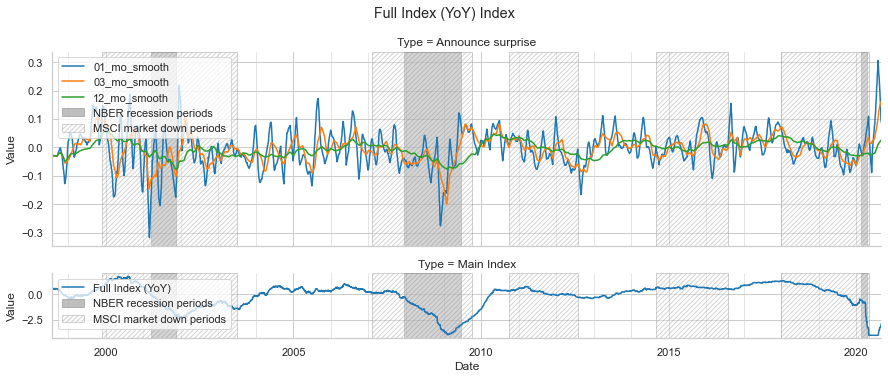

<Figure size 1080x360 with 0 Axes>

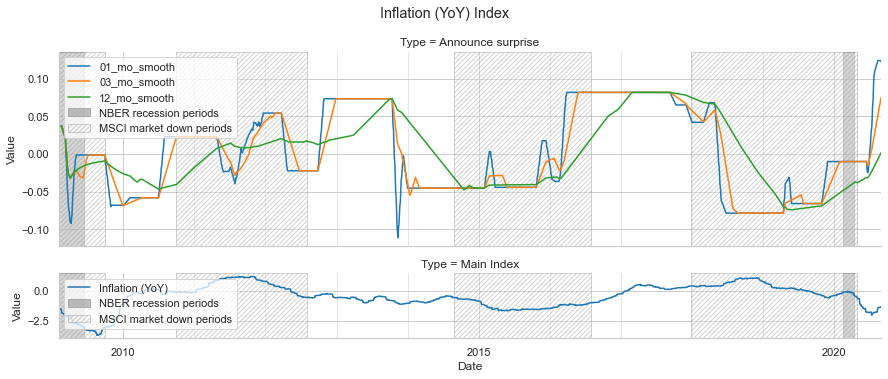

In [40]:
### RUN TO TESTING: ANNOUNCE SURPRISE INDEX VISUALIZING (MULTIPLE)

gc.collect()
### Recession periods loading:
df_nber_period = pd.read_hdf(str_path_nber_hdf, key = str_nber_periods_key)
### Market down periods loading:
df_msci_period = pd.read_hdf(str_path_msci_hdf, key = str_msci_market_down_key)  
### Global indices loading:
df_global = pd.concat([pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_full_yoy'),
                       pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_inf_yoy')], axis = 1)
### Factors loading:
df_surprise_full = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_announce)
#df_surprise_full = pd.concat(dict_surprise, axis = 1).sort_index(axis = 1)
int_iter_len = len(df_surprise_full.columns) // 2
### Factors iterating:
for iter_type in range(2):
    ### Forecast factor extracting:
    ser_surprise_iter = df_surprise_full.iloc[:, iter_type * int_iter_len : (iter_type + 1) * int_iter_len - 1].dropna().stack()
    ser_surprise_iter.index.names = ['Date', 'Smoothing_length']
    ser_surprise_iter.name = 'Announce surprise'
    str_index_name = ser_surprise_iter.index[0][1].partition('_')[0]
    ### Forecast factor preparing to visualization:
    df_surprise_iter = ser_surprise_iter.reset_index()
    df_surprise_iter['Smoothing_length'] = df_surprise_iter['Smoothing_length'].str.partition('_')[2]
    df_surprise_iter.columns = ['Date', 'Option', 'Value']
    ### Index extracting:
    ser_index_iter = df_global.iloc[:, iter_type].loc[ser_surprise_iter.index.levels[0]].dropna()
    str_index_name = ser_index_iter.name
    df_index_iter = ser_index_iter.reset_index()
    df_index_iter.columns = ['Date', 'Value']
    df_index_iter['Option'] = str_index_name
    ### Plot creation:
    sns.set_style('whitegrid')
    plt.figure(figsize = (15, 5))
    sns.set_context('notebook') 
    date_min = max([ser_surprise_iter.index[0][0], ser_index_iter.index[0]])
    date_max = min([ser_surprise_iter.index[-1][0], ser_index_iter.index[-1]])    
    df_to_plot = pd.concat([df_surprise_iter, df_index_iter], axis = 0, names = ['Type'], keys = [ser_surprise_iter.name, 'Main Index'], sort = False)\
                   .droplevel(1).reset_index()   
    grid_iter_surprise = sns.FacetGrid(data = df_to_plot, row = 'Type', height = 2.5, aspect = 5.0, legend_out = False, sharey = False,
                                       gridspec_kws = {'height_ratios': (3, 1)})
    fig_iter_surprise = grid_iter_surprise.map(sns.lineplot, 'Date', 'Value', 'Option')    
    fig_iter_surprise.fig.suptitle(str_index_name + ' Index', y = 1.05)    
    fig_iter_surprise.set(xlim = (date_min, date_max))
    ### Axes customizing:
    for iter_ax in fig_iter_surprise.axes.ravel():
        ### Recession periods visualizing;
        for iter_num, iter_row in enumerate(df_nber_period.itertuples()):
            iter_ax.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'gray', edgecolor = 'gray', alpha = 0.50, 
                            label = '_' * iter_num + 'NBER recession periods')
        for iter_num, iter_row in enumerate(df_msci_period.itertuples()):
            iter_ax.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'white', edgecolor = 'gray', alpha = 0.35, hatch = '/////', 
                            label = '_' * iter_num + 'MSCI market down periods')             ### Major ticker options:    
        iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
        iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
        ### Minor ticker options:        
        iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
        iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5)                    
        ### Separate legend for each ax:
        iter_ax.legend(loc = 'upper left', framealpha = 0.75)        
    ### Index factor plot drawing:
    plt.show()

In [34]:
### RUN TO RE-EXPORT DATA: REVISION SURPRISE INDEX CONSTRUCTING (SMOOTHED)

### Defining index vector average calculator:
def release_date_surprise(df_date, int_min_tickers_to_go):
    ser_date_surprise = (df_date['Revision_Prev'] - df_date['Release_Prev']).clip(list_clip[0], list_clip[1])
    if ser_date_surprise.count() >= int_min_tickers_to_go:
        flo_surprise = (ser_date_surprise * df_date['Ticker_Weight']).sum() / df_date['Ticker_Weight'].sum()
    else:
        flo_surprise = np.NaN
    return flo_surprise   
### Economic surprise data loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_weighted)
### Data dividing:
dict_weighted = {}
dict_weighted['Growth'] = df_surprise[df_surprise['Growth'] == True]
dict_weighted['Inflation'] = df_surprise[df_surprise['Growth'] == False]
### Factors calculating:
dict_surprise = {}
for iter_key in dict_weighted:
    ser_surprise = dict_weighted[iter_key].dropna().groupby('Release_Date').apply(release_date_surprise, int_min_tickers_to_go)
    ser_surprise.index.name = 'Date'
    ser_surprise = ser_surprise.reindex(pd.date_range(ser_surprise.index.min(), ser_surprise.index.max(), freq = 'B')).ffill()
    dict_surprise[iter_key + '_no_smooth'] = ser_surprise
    ### Looping over smoothing options:
    for iter_month_num in list_smooth:
        dict_surprise[iter_key + '_' + str(iter_month_num).zfill(2) + '_mo_smooth'] = \
                                                                    ser_surprise.rolling(window = int_bus_month * iter_month_num, min_periods = int_bus_min).mean()
#        break
#    break
### Factor saving:
pd.concat(dict_surprise, axis = 1).sort_index(axis = 1).to_hdf(str_path_bb_fcast_hdf, key = str_key_revision, mode = 'a')    

<Figure size 1080x360 with 0 Axes>

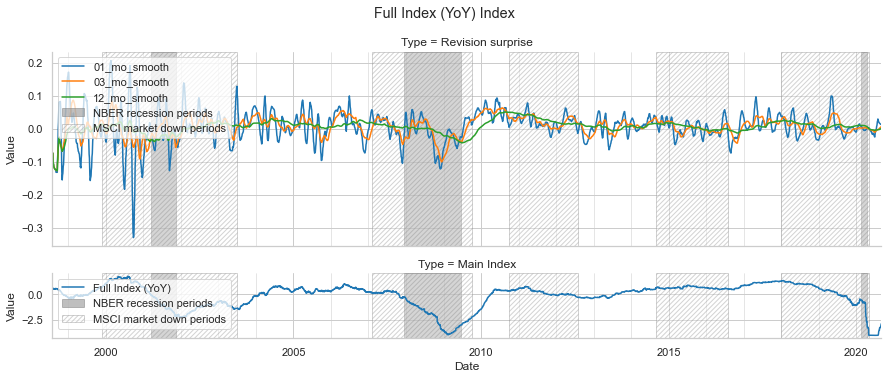

<Figure size 1080x360 with 0 Axes>

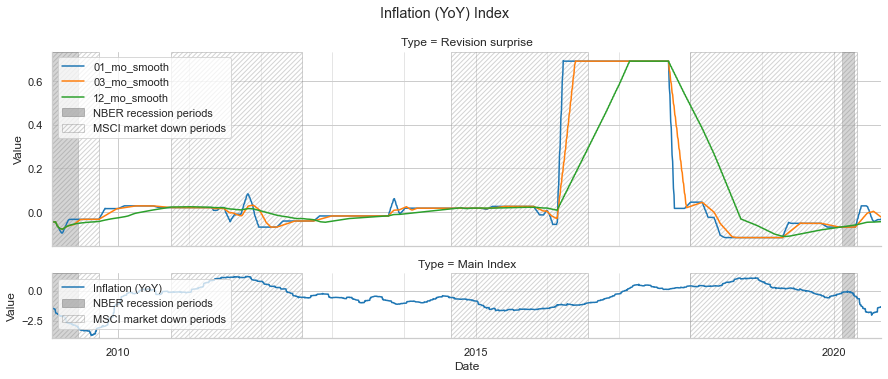

In [41]:
### RUN TO TESTING: REVISION SURPRISE INDEX VISUALIZING (MULTIPLE)

gc.collect()
### Recession periods loading:
df_nber_period = pd.read_hdf(str_path_nber_hdf, key = str_nber_periods_key)
### Market down periods loading:
df_msci_period = pd.read_hdf(str_path_msci_hdf, key = str_msci_market_down_key)  
### Global indices loading:
df_global = pd.concat([pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_full_yoy'),
                       pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_inf_yoy')], axis = 1)
### Factors loading:
df_revision_full = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_revision)
int_iter_len = len(df_revision_full.columns) // 2
### Factors iterating:
for iter_type in range(2):
    ### Forecast factor extracting:
    ser_revision_iter = df_revision_full.iloc[:, iter_type * int_iter_len : (iter_type + 1) * int_iter_len - 1].dropna().stack()
    ser_revision_iter.index.names = ['Date', 'Smoothing_length']
    ser_revision_iter.name = 'Revision surprise'
    str_index_name = ser_revision_iter.index[0][1].partition('_')[0]
    ### Forecast factor preparing to visualization:
    df_revision_iter = ser_revision_iter.reset_index()
    df_revision_iter['Smoothing_length'] = df_revision_iter['Smoothing_length'].str.partition('_')[2]
    df_revision_iter.columns = ['Date', 'Option', 'Value']
    ### Index extracting:
    ser_index_iter = df_global.iloc[:, iter_type].loc[ser_revision_iter.index.levels[0]].dropna()
    str_index_name = ser_index_iter.name
    df_index_iter = ser_index_iter.reset_index()
    df_index_iter.columns = ['Date', 'Value']
    df_index_iter['Option'] = str_index_name
    ### Plot creation:
    sns.set_style('whitegrid')
    plt.figure(figsize = (15, 5))
    sns.set_context('notebook') 
    date_min = max([ser_revision_iter.index[0][0], ser_index_iter.index[0]])
    date_max = min([ser_revision_iter.index[-1][0], ser_index_iter.index[-1]])    
    df_to_plot = pd.concat([df_revision_iter, df_index_iter], axis = 0, names = ['Type'], keys = [ser_revision_iter.name, 'Main Index'], sort = False)\
                   .droplevel(1).reset_index()   
    grid_iter_revision = sns.FacetGrid(data = df_to_plot, row = 'Type', height = 2.5, aspect = 5.0, legend_out = False, sharey = False,
                                       gridspec_kws = {'height_ratios': (3, 1)})
    fig_iter_revision = grid_iter_revision.map(sns.lineplot, 'Date', 'Value', 'Option')    
    fig_iter_revision.fig.suptitle(str_index_name + ' Index', y = 1.05)    
    fig_iter_revision.set(xlim = (date_min, date_max))
    ### Axes customizing:
    for iter_ax in fig_iter_revision.axes.ravel():
        ### Recession periods visualizing;
        for iter_num, iter_row in enumerate(df_nber_period.itertuples()):
            iter_ax.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'gray', edgecolor = 'gray', alpha = 0.50, 
                            label = '_' * iter_num + 'NBER recession periods')
        for iter_num, iter_row in enumerate(df_msci_period.itertuples()):
            iter_ax.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'white', edgecolor = 'gray', alpha = 0.35, hatch = '/////', 
                            label = '_' * iter_num + 'MSCI market down periods')             
        ### Major ticker options:    
        iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
        iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
        ### Minor ticker options:        
        iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
        iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5)                    
        ### Separate legend for each ax:
        iter_ax.legend(loc = 'upper left', framealpha = 0.75)        
    ### Index factor plot drawing:
    plt.show()

In [36]:
### RUN TO RE-EXPORT DATA: TOTAL SURPRISE INDEX CONSTRUCTING (SMOOTHED)

### Defining index vector average calculator:
def release_date_surprise(df_date, int_min_tickers_to_go):
    ser_date_announce = (df_date['Release_Value'] - df_date['Survey_Median'])
    ser_date_revision = (df_date['Revision_Prev'] - df_date['Release_Prev'])
    ser_date_surprise = pd.concat([ser_date_announce, ser_date_revision], axis = 1).mean(axis = 1).clip(list_clip[0], list_clip[1])
    if ser_date_surprise.count() >= int_min_tickers_to_go:
        flo_surprise = (ser_date_surprise * df_date['Ticker_Weight']).sum() / df_date['Ticker_Weight'].sum()
    else:
        flo_surprise = np.NaN
    return flo_surprise   
### Economic surprise data loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_weighted)
### Data dividing:
dict_weighted = {}
dict_weighted['Growth'] = df_surprise[df_surprise['Growth'] == True]
dict_weighted['Inflation'] = df_surprise[df_surprise['Growth'] == False]
### Factors calculating:
dict_surprise = {}
for iter_key in dict_weighted:
    ser_surprise = dict_weighted[iter_key].dropna().groupby('Release_Date').apply(release_date_surprise, int_min_tickers_to_go)
    ser_surprise.index.name = 'Date'
    ser_surprise = ser_surprise.reindex(pd.date_range(ser_surprise.index.min(), ser_surprise.index.max(), freq = 'B')).ffill()
    dict_surprise[iter_key + '_no_smooth'] = ser_surprise
    ### Looping over smoothing options:
    for iter_month_num in list_smooth:
        dict_surprise[iter_key + '_' + str(iter_month_num).zfill(2) + '_mo_smooth'] = \
                                                                    ser_surprise.rolling(window = int_bus_month * iter_month_num, min_periods = int_bus_min).mean()
#        break
#    break
### Factor saving:
pd.concat(dict_surprise, axis = 1).sort_index(axis = 1).to_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise, mode = 'a')    

<Figure size 1080x360 with 0 Axes>

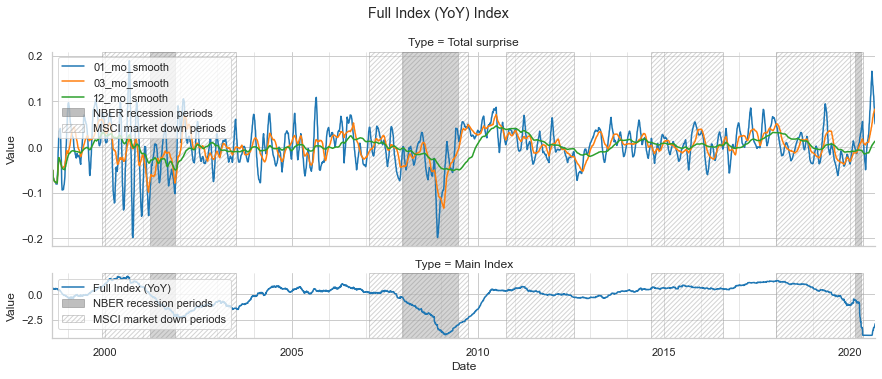

<Figure size 1080x360 with 0 Axes>

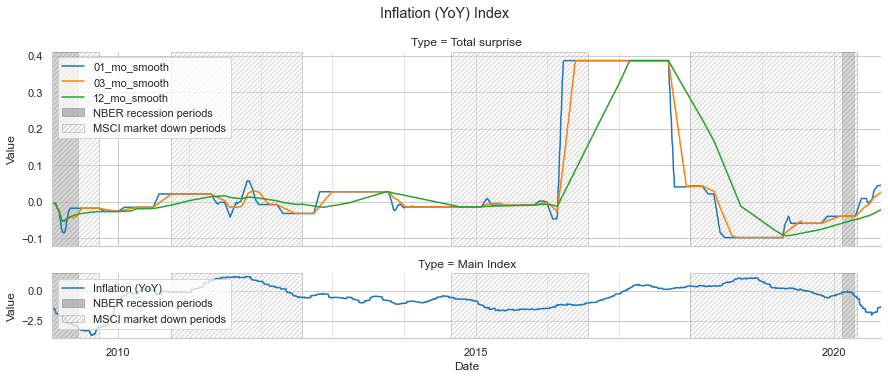

In [42]:
### RUN TO TESTING: TOTAL SURPRISE INDEX VISUALIZING (MULTIPLE)

gc.collect()
### Recession periods loading:
df_nber_period = pd.read_hdf(str_path_nber_hdf, key = str_nber_periods_key)
### Market down periods loading:
df_msci_period = pd.read_hdf(str_path_msci_hdf, key = str_msci_market_down_key)  
### Global indices loading:
df_global = pd.concat([pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_full_yoy'),
                       pd.read_hdf(str_path_bb_diag_hdf, key = 'global_diagonal_inf_yoy')], axis = 1)
### Factors loading:
df_total_full = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise)
int_iter_len = len(df_total_full.columns) // 2
### Factors iterating:
for iter_type in range(2):
    ### Forecast factor extracting:
    ser_total_iter = df_total_full.iloc[:, iter_type * int_iter_len : (iter_type + 1) * int_iter_len - 1].dropna().stack()
    ser_total_iter.index.names = ['Date', 'Smoothing_length']
    ser_total_iter.name = 'Total surprise'
    str_index_name = ser_total_iter.index[0][1].partition('_')[0]
    ### Forecast factor preparing to visualization:
    df_total_iter = ser_total_iter.reset_index()
    df_total_iter['Smoothing_length'] = df_total_iter['Smoothing_length'].str.partition('_')[2]
    df_total_iter.columns = ['Date', 'Option', 'Value']
    ### Index extracting:
    ser_index_iter = df_global.iloc[:, iter_type].loc[ser_total_iter.index.levels[0]].dropna()
    str_index_name = ser_index_iter.name
    df_index_iter = ser_index_iter.reset_index()
    df_index_iter.columns = ['Date', 'Value']
    df_index_iter['Option'] = str_index_name
    ### Plot creation:
    sns.set_style('whitegrid')
    plt.figure(figsize = (15, 5))
    sns.set_context('notebook') 
    date_min = max([ser_total_iter.index[0][0], ser_index_iter.index[0]])
    date_max = min([ser_total_iter.index[-1][0], ser_index_iter.index[-1]])    
    df_to_plot = pd.concat([df_total_iter, df_index_iter], axis = 0, names = ['Type'], keys = [ser_total_iter.name, 'Main Index'], sort = False)\
                   .droplevel(1).reset_index()   
    grid_iter_total = sns.FacetGrid(data = df_to_plot, row = 'Type', height = 2.5, aspect = 5.0, legend_out = False, sharey = False,
                                       gridspec_kws = {'height_ratios': (3, 1)})
    fig_iter_total = grid_iter_total.map(sns.lineplot, 'Date', 'Value', 'Option')    
    fig_iter_total.fig.suptitle(str_index_name + ' Index', y = 1.05)    
    fig_iter_total.set(xlim = (date_min, date_max))
    ### Axes customizing:
    for iter_ax in fig_iter_total.axes.ravel():
        ### Recession periods visualizing;
        for iter_num, iter_row in enumerate(df_nber_period.itertuples()):
            iter_ax.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'gray', edgecolor = 'gray', alpha = 0.50, 
                            label = '_' * iter_num + 'NBER recession periods')
        for iter_num, iter_row in enumerate(df_msci_period.itertuples()):
            iter_ax.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'white', edgecolor = 'gray', alpha = 0.35, hatch = '/////', 
                            label = '_' * iter_num + 'MSCI market down periods')             
        ### Major ticker options:    
        iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
        iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
        ### Minor ticker options:        
        iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
        iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5)                    
        ### Separate legend for each ax:
        iter_ax.legend(loc = 'upper left', framealpha = 0.75)        
    ### Index factor plot drawing:
    plt.show()

<Figure size 1080x360 with 0 Axes>

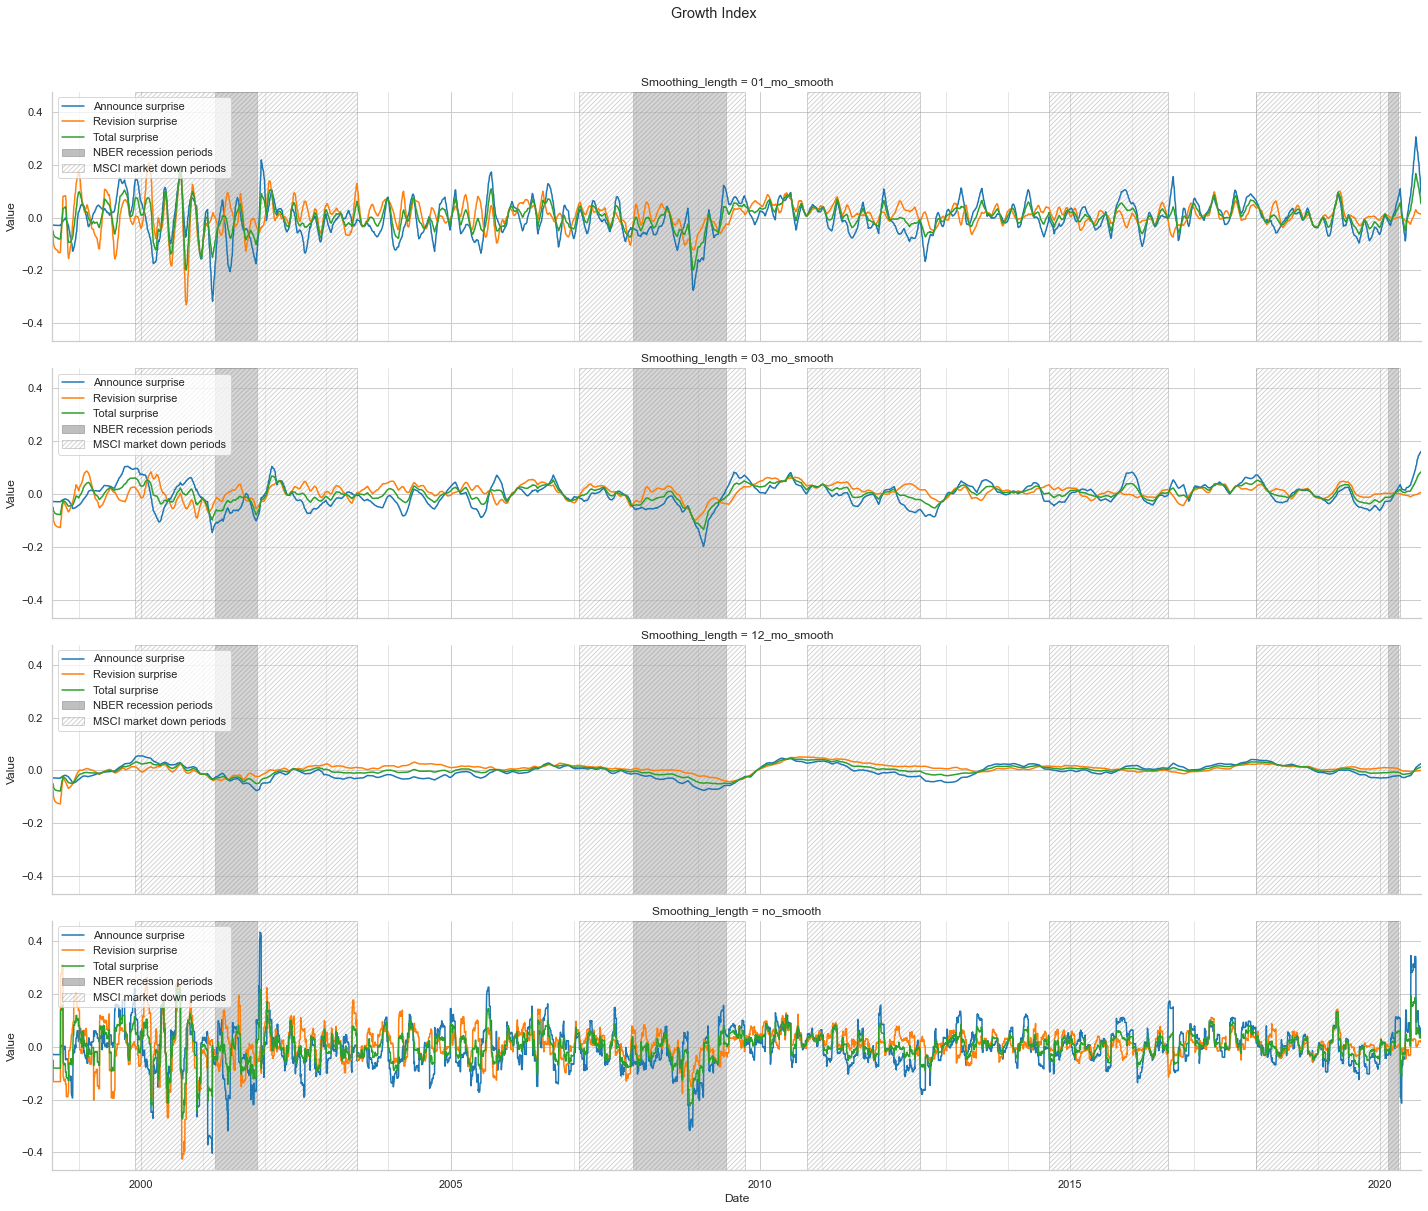

<Figure size 1080x360 with 0 Axes>

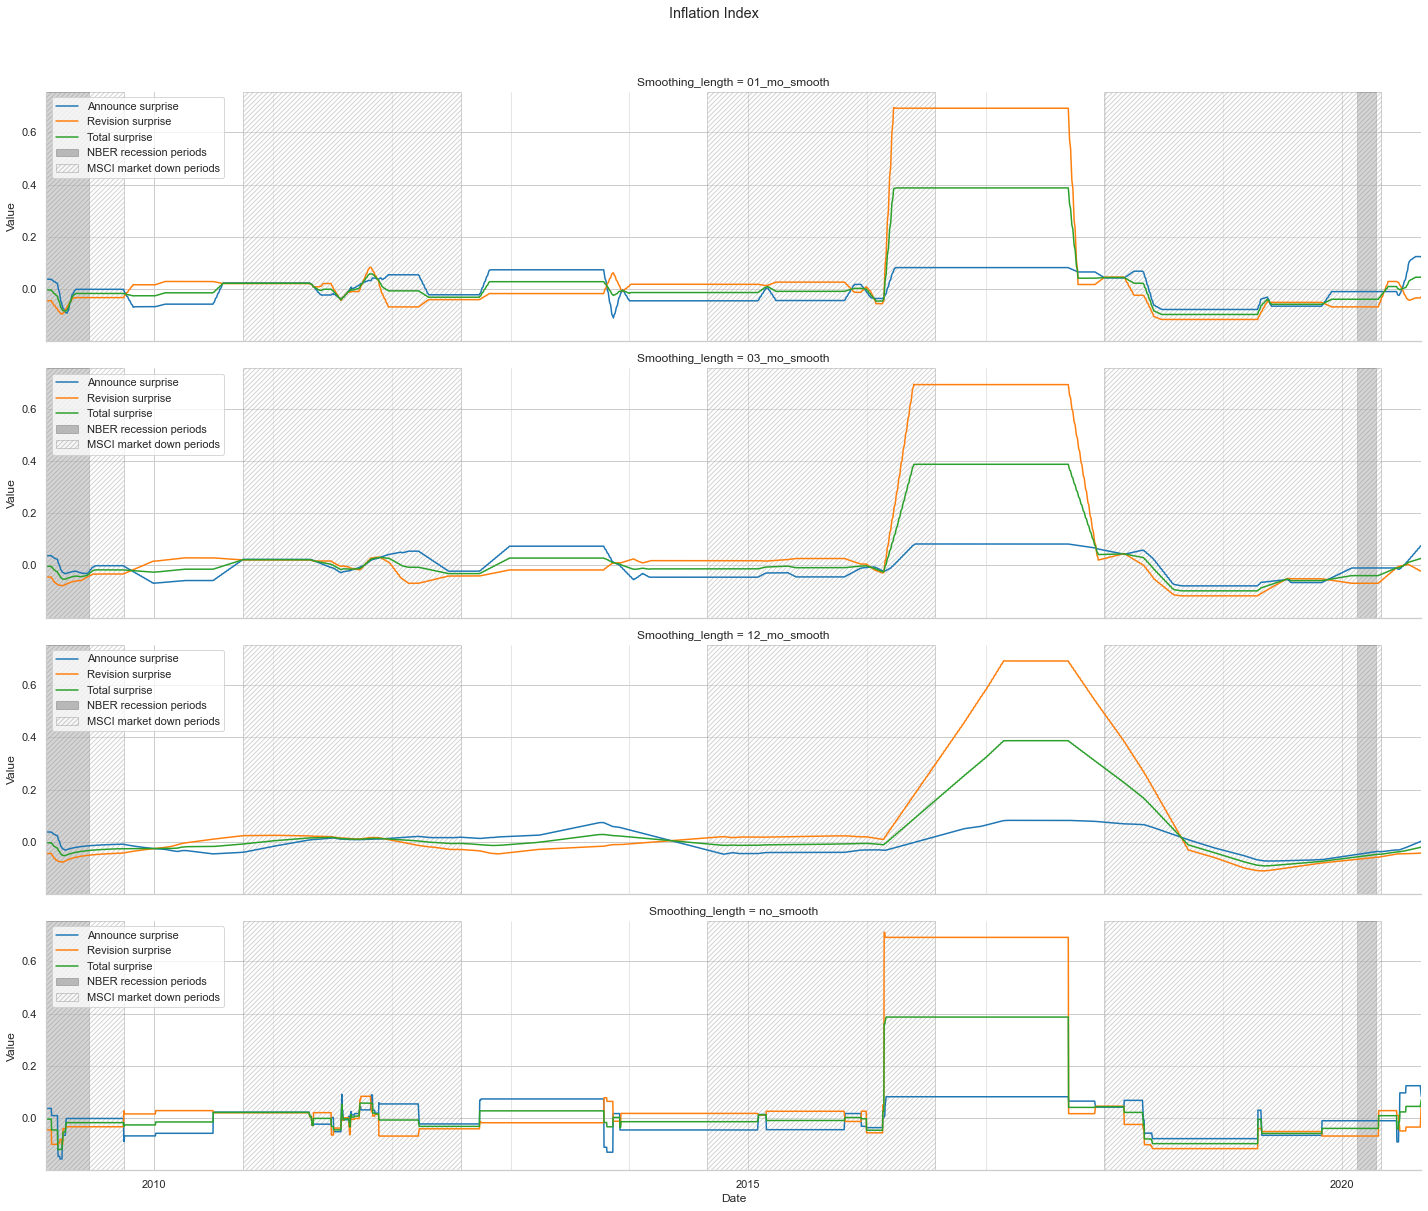

In [43]:
### RUN TO TESTING: SURPRISE INDICES COMPARISION (MULTIPLE)

gc.collect()
### Recession periods loading:
df_nber_period = pd.read_hdf(str_path_nber_hdf, key = str_nber_periods_key)
### Market down periods loading:
df_msci_period = pd.read_hdf(str_path_msci_hdf, key = str_msci_market_down_key)  
### Factors loading:
df_revision_full = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_revision)
df_announce_full = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_announce)
df_total_full = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise)
int_iter_len = len(df_revision_full.columns) // 2
### Factors iterating:
for iter_type in range(2):
    ### Forecast factors extracting:
    ser_announce_iter = df_announce_full.iloc[:, iter_type * int_iter_len : (iter_type + 1) * int_iter_len].dropna().stack()
    ser_announce_iter.index.names = ['Date', 'Smoothing_length']
    ser_announce_iter.name = 'Announce surprise'
    ser_revision_iter = df_revision_full.iloc[:, iter_type * int_iter_len : (iter_type + 1) * int_iter_len].dropna().stack()
    ser_revision_iter.index.names = ['Date', 'Smoothing_length']
    ser_revision_iter.name = 'Revision surprise'
    ser_total_iter = df_total_full.iloc[:, iter_type * int_iter_len : (iter_type + 1) * int_iter_len].dropna().stack()
    ser_total_iter.index.names = ['Date', 'Smoothing_length']
    ser_total_iter.name = 'Total surprise'
    str_index_name = ser_announce_iter.index[0][1].partition('_')[0]     
    ### Forecast factor preparing to visualization:
    ser_forecast_iter = pd.concat([ser_announce_iter, ser_revision_iter, ser_total_iter], axis = 1).stack()
    ser_forecast_iter.index.names = ['Date', 'Smoothing_length', 'Factor']
    ser_forecast_iter.name = 'Value'
    ### Plot creation:
    sns.set_style('whitegrid')
    plt.figure(figsize = (15, 5))
    sns.set_context('notebook') 
    date_min = max([ser_announce_iter.index[0][0], ser_revision_iter.index[0][0], ser_total_iter.index[0][0]])
    date_max = min([ser_announce_iter.index[-1][0], ser_revision_iter.index[-1][0], ser_total_iter.index[-1][0]])
    df_to_plot = ser_forecast_iter.reset_index()   
    df_to_plot['Smoothing_length'] = df_to_plot['Smoothing_length'].str.partition('_')[2]
    grid_iter_surprise = sns.FacetGrid(data = df_to_plot, row = 'Smoothing_length', height = 4.0, aspect = 5.0, legend_out = False, sharey = True)
    fig_iter_surprise = grid_iter_surprise.map(sns.lineplot, 'Date', 'Value', 'Factor')    
    fig_iter_surprise.fig.suptitle(str_index_name + ' Index', y = 1.05)    
    fig_iter_surprise.set(xlim = (date_min, date_max))
    ### Axes customizing:
    for iter_ax in fig_iter_surprise.axes.ravel():
        ### Recession periods visualizing;
        for iter_num, iter_row in enumerate(df_nber_period.itertuples()):
            iter_ax.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'gray', edgecolor = 'gray', alpha = 0.50, 
                            label = '_' * iter_num + 'NBER recession periods')
        for iter_num, iter_row in enumerate(df_msci_period.itertuples()):
            iter_ax.axvspan(iter_row.Beg_Date, iter_row.End_Date, facecolor = 'white', edgecolor = 'gray', alpha = 0.35, hatch = '/////', 
                            label = '_' * iter_num + 'MSCI market down periods')             
        ### Major ticker options:    
        iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
        iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
        ### Minor ticker options:        
        iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
        iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5)                    
        ### Separate legend for each ax:
        iter_ax.legend(loc = 'upper left', framealpha = 0.75)        
    ### Index factor plot drawing:
    plt.show()

In [45]:
### RUN TO TESTING: SURPRISE FACTORS COMPARING

### Alternative results loading:
df_announce_matrix = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_announce)
df_revision_matrix = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_revision)
df_total_matrix = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise)
### Column-wise correlation performing:
for iter_smooth in range(4):
    print(df_announce_matrix.columns[iter_smooth], ': matrix normalized forecast factors comparision:\n') 
    display(pd.concat([df_announce_matrix[df_announce_matrix.columns[iter_smooth]], 
                       df_revision_matrix[df_revision_matrix.columns[iter_smooth]], 
                       df_total_matrix[df_total_matrix.columns[iter_smooth]]], 
                       axis = 1, keys = ['Announcement Surprise', 'Revision Surprise', 'Total Surprise']).corr())

Growth_01_mo_smooth : matrix normalized forecast factors comparision:



,Announcement Surprise,Revision Surprise,Total Surprise
Announcement Surprise,1.000000,0.198182,0.843798
Revision Surprise,0.198182,1.000000,0.693241
Total Surprise,0.843798,0.693241,1.000000


Growth_03_mo_smooth : matrix normalized forecast factors comparision:



,Announcement Surprise,Revision Surprise,Total Surprise
Announcement Surprise,1.000000,0.234698,0.872763
Revision Surprise,0.234698,1.000000,0.679345
Total Surprise,0.872763,0.679345,1.000000


Growth_12_mo_smooth : matrix normalized forecast factors comparision:



,Announcement Surprise,Revision Surprise,Total Surprise
Announcement Surprise,1.000000,0.484361,0.898273
Revision Surprise,0.484361,1.000000,0.819539
Total Surprise,0.898273,0.819539,1.000000


Growth_no_smooth : matrix normalized forecast factors comparision:



,Announcement Surprise,Revision Surprise,Total Surprise
Announcement Surprise,1.000000,0.204219,0.831384
Revision Surprise,0.204219,1.000000,0.713771
Total Surprise,0.831384,0.713771,1.000000


In [46]:
### RUN TO TESTING: SURPRISE FACTORS CALCULATION METHODS COMPARING

### Alternative results loading:
df_announce_matrix = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_announce)
df_revision_matrix = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_revision)
df_total_matrix = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise)
### Alternative results loading:
df_announce_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_announce)
df_revision_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_revision)
df_total_std = pd.read_hdf('Data_Files/Source_Files/Bloomberg_Forecasts_std.h5', key = str_key_total_surprise)
### Pairwise correlations:
print('Announce surprise correlation beteween matrix normalized and std normalized versions:\n', 
      df_announce_matrix[df_announce_matrix.columns[:4]].corrwith(df_announce_std[df_announce_std.columns[:4]]))
print('Revision surprise correlation beteween matrix normalized and std normalized versions:\n', 
      df_revision_matrix[df_revision_matrix.columns[:4]].corrwith(df_revision_std[df_revision_std.columns[:4]]))
print('Total surprise correlation beteween matrix normalized and std normalized versions:\n', 
      df_total_matrix[df_total_matrix.columns[:4]].corrwith(df_total_std[df_total_std.columns[:4]]))

Announce surprise correlation beteween matrix normalized and std normalized versions:
 Growth_01_mo_smooth    0.707774
Growth_03_mo_smooth    0.761995
Growth_12_mo_smooth    0.842914
Growth_no_smooth       0.699118
dtype: float64
Revision surprise correlation beteween matrix normalized and std normalized versions:
 Growth_01_mo_smooth    0.417727
Growth_03_mo_smooth    0.541825
Growth_12_mo_smooth    0.702756
Growth_no_smooth       0.364875
dtype: float64
Total surprise correlation beteween matrix normalized and std normalized versions:
 Growth_01_mo_smooth    0.688778
Growth_03_mo_smooth    0.750998
Growth_12_mo_smooth    0.773634
Growth_no_smooth       0.653711
dtype: float64


In [ ]:
### TEMP

### Defining index vector average calculator:
def release_date_surprise(df_date, int_min_tickers_to_go):
    ser_date_surprise = (df_date['Release_Value'] - df_date['Survey_Median']).clip(list_clip[0], list_clip[1])
    if ser_date_surprise.count() >= int_min_tickers_to_go:
        flo_surprise = (ser_date_surprise * df_date['Ticker_Weight']).sum() / df_date['Ticker_Weight'].sum()
        print(df_date.index[0][1], ':', ser_date_surprise.count())
    else:
        flo_surprise = np.NaN
    return flo_surprise   
### Economic surprise data loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_weighted)
df_test = df_surprise[df_surprise['Growth'] == False]
ser_surprise = df_test.dropna().groupby('Release_Date').apply(release_date_surprise, int_min_tickers_to_go)
ser_surprise.index.name = 'Date'
ser_surprise = ser_surprise.reindex(pd.date_range(ser_surprise.index.min(), ser_surprise.index.max(), freq = 'B')).ffill()